In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
sns.set_style("darkgrid")
sns.set_palette("rocket")
# sns.set_palette("mako")
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

pi = np.pi

In [2]:
def autocovariance(k, H):
        return 0.5 * (abs(k - 1) ** (2 * H) - 2 * abs(k) ** (2 * H) + abs(k + 1) ** (2 * H))

def cholesky_fbm(T, n, H, trajectories = 1, G = None, C = None):
    scale = (T /n) ** H
    if not G:
        G = np.zeros([n, n])
        for i in range(n):
            for j in range(i + 1):
                G[i, j] = autocovariance(i - j, H)
    if not C:
        C = np.linalg.cholesky(G)
    gn = np.random.normal(0.0, 1.0, (trajectories, n))
    fgn = np.dot(C, gn.T) * scale
    return np.insert(np.cumsum(fgn, 0)[:-1], 0, 0, axis=0)

def get_quantils(df, quantiles, ts):
    N = df.shape[0]
    qs = np.zeros((N, len(quantiles)))
    for i, row in df.iterrows():
        qs[i]= [np.quantile(row, q) for q in quantiles] 
    quantiles_Df = pd.DataFrame(qs.T, columns = ts)
    quantiles_Df["rang"] = quantiles
    return quantiles_Df


In [3]:
def EAMSD(df):
    x_0 = df[0]
    diff_sq = (df - x_0)**2
    return np.mean(diff_sq, 1)

def TAMSD(df, tau):
    return np.mean(np.diff(df, tau, 0)**2, 0)

In [4]:
def FOU(sigma, lambd, H, ts, trajectories = 1):
    n = len(ts)
    T = ts[-1]
    tsM = np.repeat(ts[:, None],  trajectories, 1)
    exp_lamd_t = np.exp(-lambd*tsM)
    fbm = cholesky_fbm(T, n+1, H, trajectories=trajectories)
    diff_fbm = np.diff(fbm, axis=0)
    O_u = sigma *exp_lamd_t * np.cumsum(np.exp(lambd*tsM)*diff_fbm, 0)  
    return O_u

In [5]:
def stable_random_variables_a(alpha):
    if alpha == 1:
        Omega = np.random.uniform(-pi/2, pi/2)
        return np.tan(Omega)
    else:
        Omega = np.random.uniform(-pi/2, pi/2)
        W = np.random.exponential(1)
        return np.sin(alpha*Omega)/np.cos(Omega)**(1/alpha)*(np.cos((alpha-1)*Omega)/W)**((1-alpha)/alpha)
    
def stable_random_variables_b(alpha, beta):
    Omega = np.random.uniform(-pi/2, pi/2)
    W = np.random.exponential(1)
    Delta_0 = np.arctan(beta*np.tan(pi*alpha/2))/alpha

    if alpha == 1:
        return 2/pi*((pi/2+beta*Omega)*np.tan(Omega)-beta*np.log(pi/2*W*np.cos(Omega)/(pi/2+beta*Omega)))
    else:
        a = np.sin(alpha*(Delta_0+Omega))/(np.cos(alpha*Delta_0)*np.cos(Omega))**(1/alpha)
        b = (np.cos(alpha*Delta_0+(alpha-1)*Omega)/W)**((1-alpha)/alpha)
        return a*b

def stable_random_variables_0(alpha, beta, gamma, delta):
    Z = stable_random_variables_a(alpha, beta)
    if alpha == 1:
        return gamma*Z+delta
    else:
        return gamma*(Z - beta*np.tan(pi*alpha/2)) + delta


def stable_random_variables_1(alpha, beta, gamma, delta):
    Z = stable_random_variables_b(alpha, beta)
    if alpha == 1:
        return gamma*Z + (delta + beta*2/pi*gamma*np.log(gamma))
    else:
        return gamma*Z+delta
    
def stable_random_variables(alpha, beta = 0, gamma=1, delta=0, stable_type = 1):
    if stable_type == 1:
        return stable_random_variables_1(alpha, beta, gamma, delta)
    elif stable_type ==0:
        return stable_random_variables_0(alpha, beta, gamma, delta)
    else:
        raise ValueError("Select bad stable_type!!!")
    
def  alpha_stable_process(alpha, beta, N, T=1, S_0 = 0):
    dt = T / N
    Z_t = [stable_random_variables(alpha, beta, gamma = dt**(1/alpha)) for _ in range(N)] 
    Z_t[0] = S_0
    return np.cumsum(Z_t)

In [6]:
def FAS(alpha, H, M, N, m, n):
    C =  (T /N) ** H
    mh = 1 / m
    d = H - 1 / alpha
    t0 = np.arange(mh, 1 + mh, mh)
    t1 = np.arange(1 + mh, M + mh, mh)
    A = mh**(1/alpha) * np.concatenate((t0**d, t1**d - (t1 - 1)**d))
    
    mh = 1 / m
    d = H - 1 / alpha
    t0 = np.arange(mh, 1 + mh, mh)
    t1 = np.arange(1 + mh, M + mh, mh)
    A = mh**(1/alpha) * np.concatenate((t0**d, t1**d - (t1 - 1)**d))

    C = C * (np.sum(np.abs(A)**alpha)**(-1/alpha))
    A = C * A

    Na = m * (M + N)
    A = np.fft.fft(A, Na)
    y= np.zeros((n, N))
    # y=[]
    for i in range(n):
        if alpha < 2:
            Z = np.array([stable_random_variables(alpha, 0) for _ in range(Na)])[None,:]
        elif alpha == 2:
            Z = np.random.randn(1, Na)

        Z = np.fft.fft(Z, Na)
        w = np.real(np.fft.ifft(Z * A, Na))
        y[i] = w[0][:N*m:m]
    return np.array(y)

# FBM

## (a) sample trajectories

In [7]:
T = 1
n = 2000
H = 0.5
t_s = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 50)

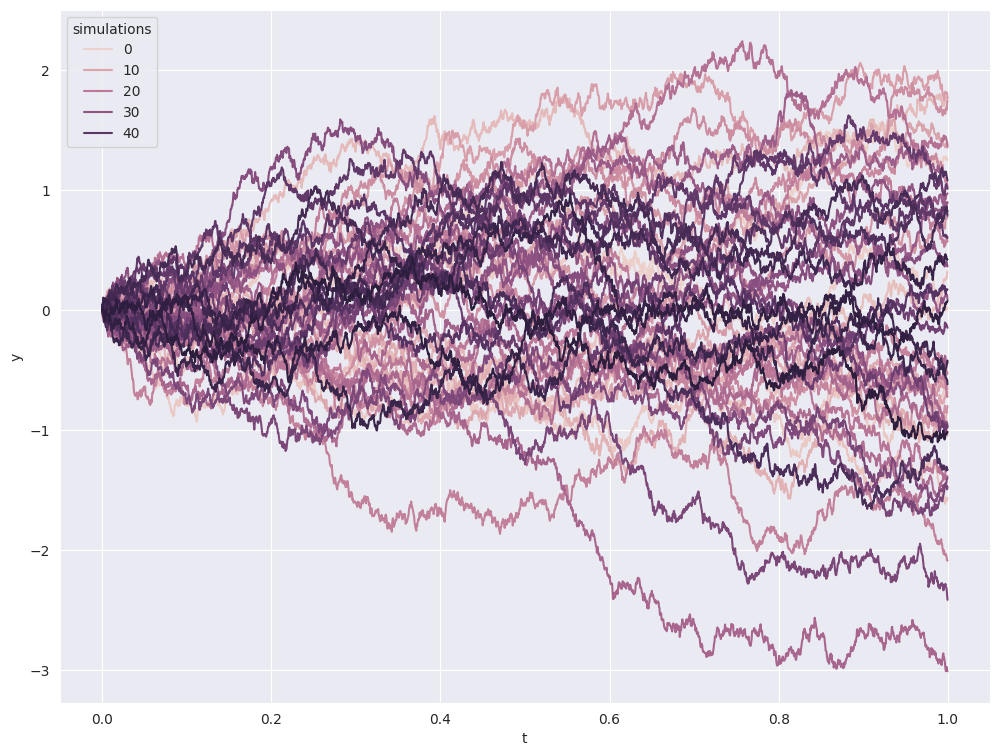

In [9]:
fig, ax=plt.subplots(figsize=(12, 9))

df_BH = pd.DataFrame(fbm)
df_BH["t"] = t_s
melt_df_BH = pd.melt(df_BH, "t", var_name="simulations", value_name="y")
sns.lineplot(melt_df_BH , x = "t", y = "y", hue ="simulations")
plt.savefig(f"latex/images/sample_trajectories_FBM_H_{H}.png")

## Quantile line

In [44]:
T = 1
n = 1000
H = 0.666
t_s = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 1000)

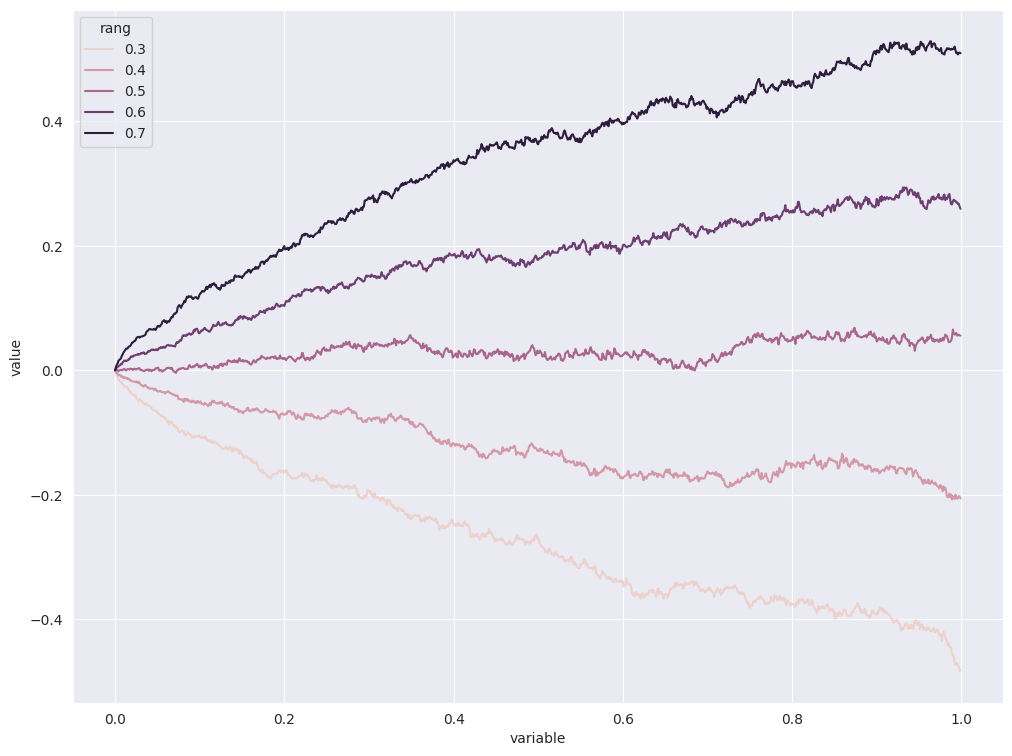

In [45]:
fig, ax=plt.subplots(figsize=(12, 9))
quantiles = np.arange(0.3, 0.8, 0.1)
quantiles_Df = get_quantils(pd.DataFrame(fbm), quantiles, t_s)
quantiles_Df["rang"] = quantiles_Df["rang"].round(2) 
sns.lineplot(quantiles_Df.melt("rang"), x="variable", y="value", hue="rang")
plt.savefig("latex/images/quantile_lines_FBM_H_{H}.png")

## Variancve in time

In [55]:
T = 1
n = 100
H = 0.5
ts = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 1000)

In [75]:
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["var", "t", "H"])
for H in np.arange(dH, 1, dH):
    fbm = cholesky_fbm(T, n, H, trajectories)
    _df = pd.DataFrame(np.var(fbm, 1), columns=["var"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])

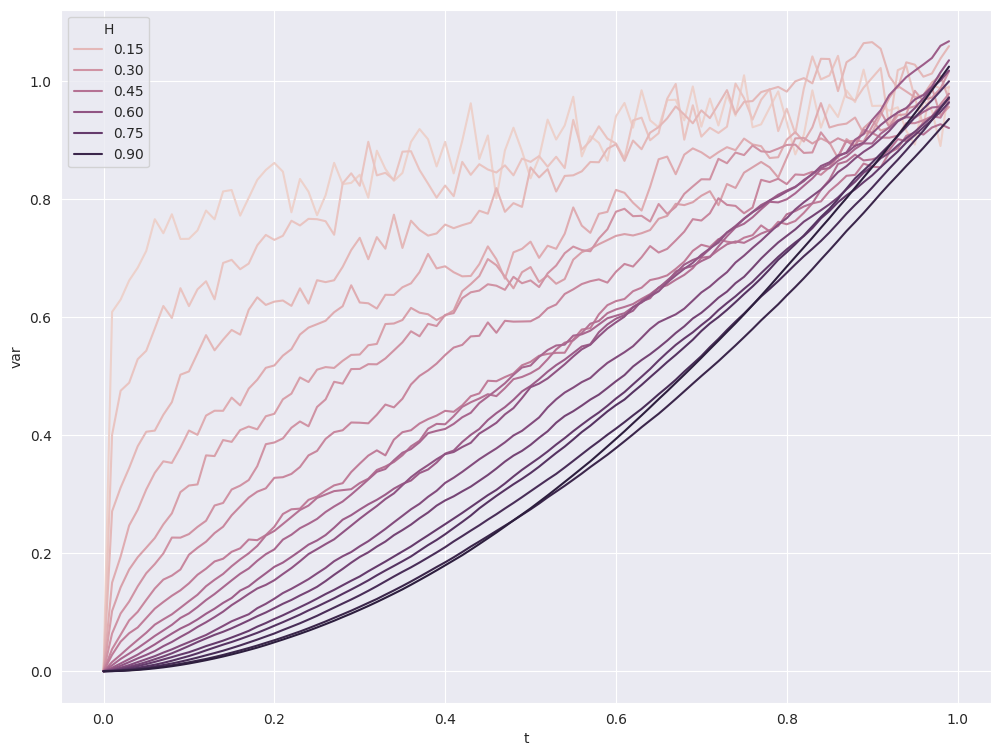

In [77]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(df, x = "t", y = "var", hue = "H")
plt.savefig("latex/images/variance_FBM.png")
plt.show()

## MSD

In [112]:
T = 1
n = 100
H = 0.5
ts = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 1000)
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["EA-MSD", "t", "H"])
for H in np.arange(dH, 1, dH):
    fbm = cholesky_fbm(T, n, H, trajectories)
    _df = pd.DataFrame(EAMSD(fbm), columns=["EA-MSD"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])

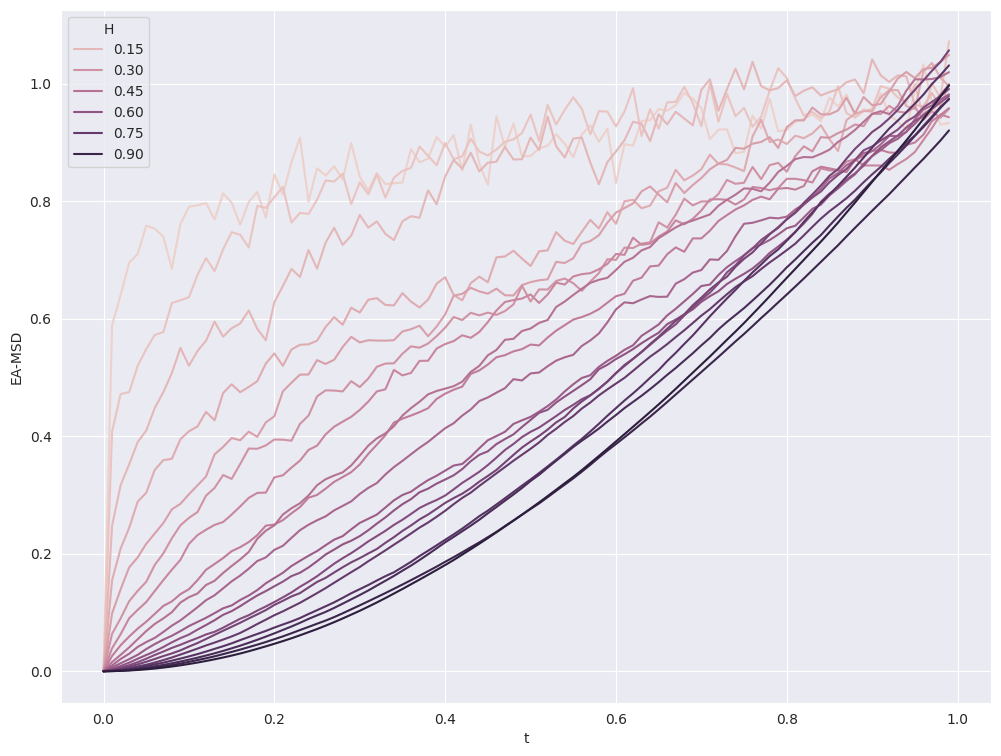

In [113]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(df, x = "t", y = "EA-MSD", hue = "H")
plt.savefig("latex/images/EA-MSD_FBM.png")
plt.show()

In [48]:
T = 1
n = 1000
ts = np.arange(0, T, T/n)
dH = 0.1
trajectories = 20
df = pd.DataFrame()
ks = range(trajectories)
Hs = np.arange(0.1, 1, dH).round(2)
taus = np.arange(1, 10, 1, dtype=int)
for H in Hs: 
    for tau in taus:
        fbm = cholesky_fbm(T, n, H, trajectories)
        _df = pd.DataFrame(TAMSD(fbm, tau), columns=["TAMSD"])
        _df["k"] = ks
        _df["tau"] = tau
        _df["H"] = H
        df = pd.concat([df, _df])
TAMSD_df = df.pivot_table(index = ["H","tau"], values="TAMSD", aggfunc="mean").reset_index()

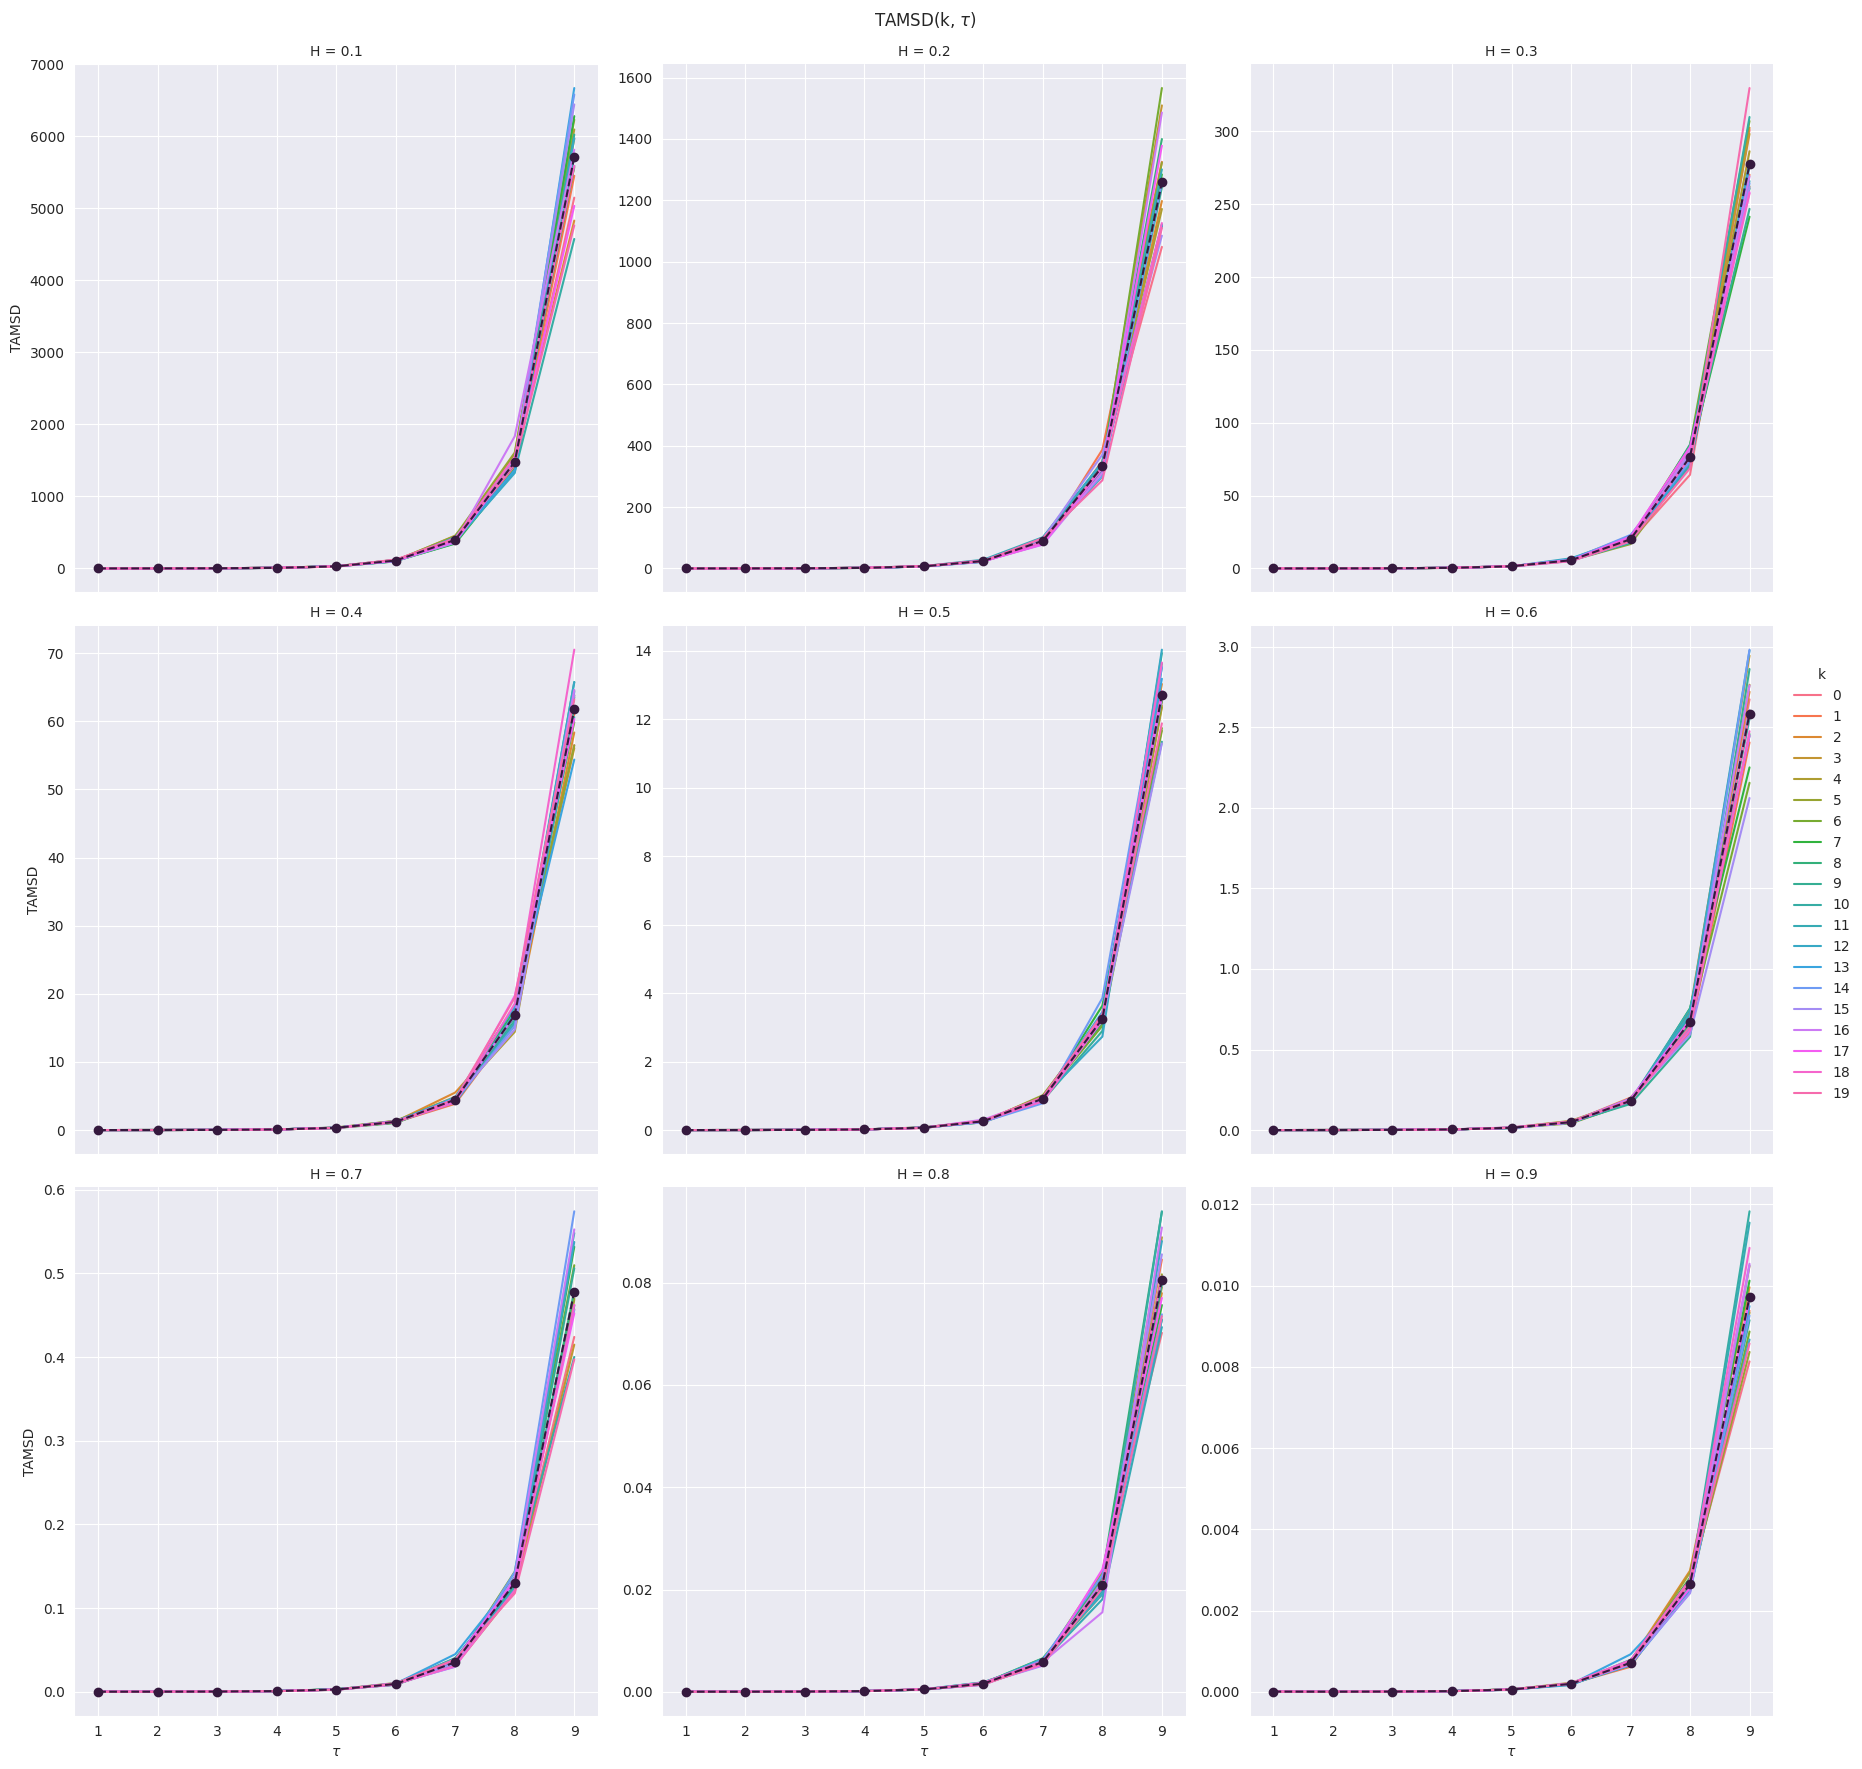

In [251]:
g = sns.FacetGrid(df, col="H", col_wrap=3 , hue="k",  height=6, sharey=False)
g.map(sns.lineplot, "tau", "TAMSD")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("TAMSD(k, $\\tau$)")

for ax, H in zip(g.axes, Hs):
    data = TAMSD_df.query(f"H == {H}")
    ax.plot(taus,data["TAMSD"].values, "--", marker="o", label="test")
    ax.set_xlabel("$\\tau$")
g.add_legend()
plt.show()

## questions

In [140]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
fbm = cholesky_fbm(T, n, H, trajectories= 1)

### stationary process

In [296]:
# Augmented Dickey-Fuller test
adfuller(fbm)[1] #pvalue> 0.05 so no stationary


0.26798740069464116

In [145]:
kpss(fbm)[1] #pvalue < 0.05 so no stationary

/home/olek/.local/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


0.01

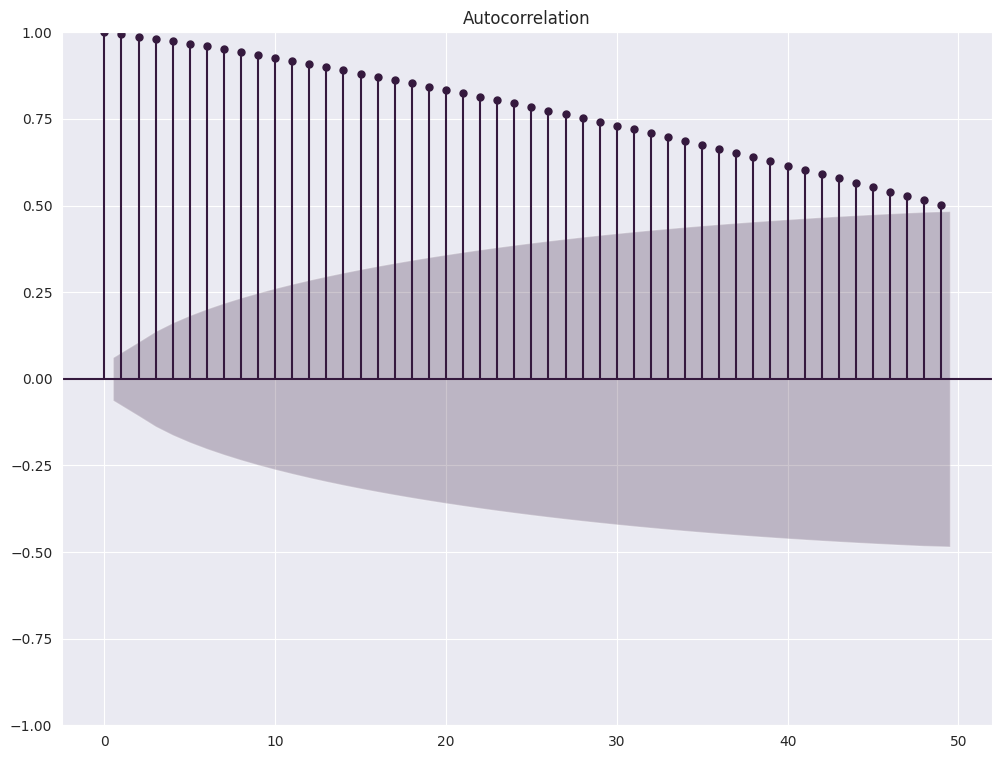

In [288]:
fig, ax=plt.subplots(figsize=(12, 9))
plot_acf(fbm, ax=ax, lags = range(0,50))
plt.show()

### are increments of the process stationary

In [313]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n), 
fbm = cholesky_fbm(T, n, H, trajectories= 1)
fbm_2 = cholesky_fbm(T/n, 2, H, trajectories= 2000)[-1]

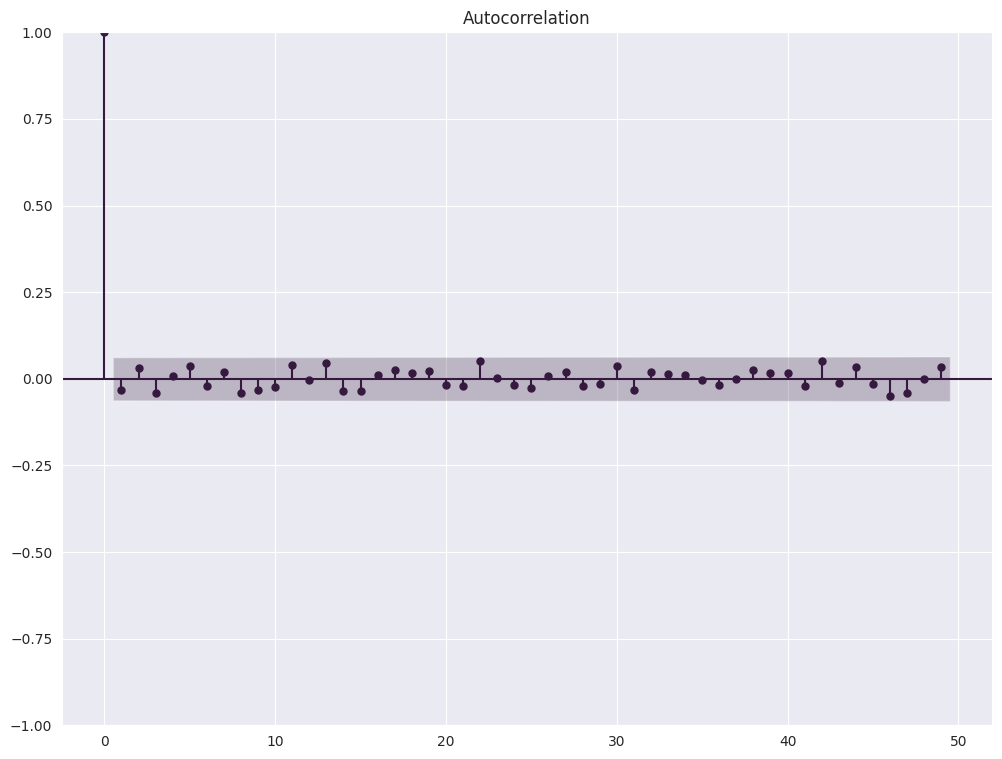

In [264]:
fig, ax=plt.subplots(figsize=(12, 9))
plot_acf(np.diff(fbm,1,0), ax=ax, lags = range(0,50))
plt.show()

In [318]:
adfuller(np.diff(fbm,1,0))[1] #pvalue < 0.05 so stationary


0.0

In [148]:
kpss(np.diff(fbm,1,0))[1] #pvalue > 0.05 so stationary

/home/olek/.local/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


0.1

### process distribution 

Process is gausain

In [387]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n), 
fix_fbm = cholesky_fbm(T, n, H, trajectories= 2000)[-1]

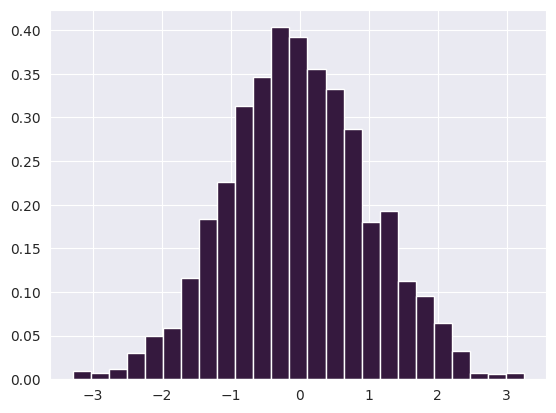

In [388]:
plt.hist(fix_fbm, bins = 25,density = True)
plt.show()

In [389]:
stats.shapiro(fix_fbm), stats.kstest(fix_fbm, 'norm'), stats.normaltest(fix_fbm), stats.jarque_bera(fix_fbm)

(ShapiroResult(statistic=0.9988774061203003, pvalue=0.23327530920505524),
 KstestResult(statistic=0.023171353713519194, pvalue=0.22958481566493494, statistic_location=-0.24990955661312358, statistic_sign=1),
 NormaltestResult(statistic=0.6340378628052985, pvalue=0.72831696693343),
 SignificanceResult(statistic=0.6496249959574791, pvalue=0.72266284168304))

### process increments distribution 

In [395]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n), 
fbm = cholesky_fbm(T, n, H, trajectories= 1)
diff_fix_fbm =  np.diff(np.squeeze(fbm))
teo_fbm = cholesky_fbm(T/n, n, H, trajectories= 2000)[-1]


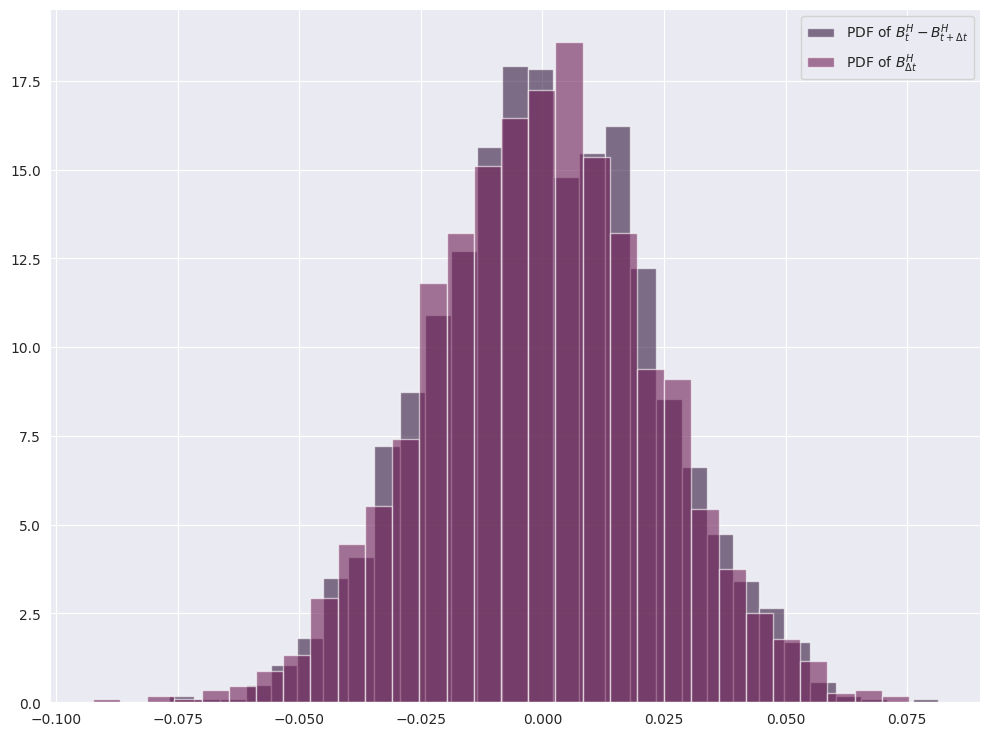

In [404]:
fig, ax=plt.subplots(figsize=(12, 9))
plt.hist(diff_fix_fbm, density=True, bins = 30, label = "PDF of $B^H_{t} - B^H_{t+\Delta t}$", alpha = 0.6)
plt.hist(teo_fbm, density=True, bins = 30, label = "PDF of $B^H_{\Delta t}$", alpha = 0.6)
plt.legend()
plt.show()

In [405]:
stats.kstest(diff_fix_fbm, teo_fbm) # duze p valiu nie odzucamy

KstestResult(statistic=0.025655077538769385, pvalue=0.5155017809109428, statistic_location=0.01230147568963988, statistic_sign=-1)

Quantile line fulfills power-low

## Self-similar

In [149]:
T = 10
n = 2000
H = 0.5
ts = np.arange(0, T, T/n), 
fbm_1 = cholesky_fbm(T, n, H, trajectories=2000)
fbm_2 = cholesky_fbm(1, n, H, trajectories=2000)*T**H

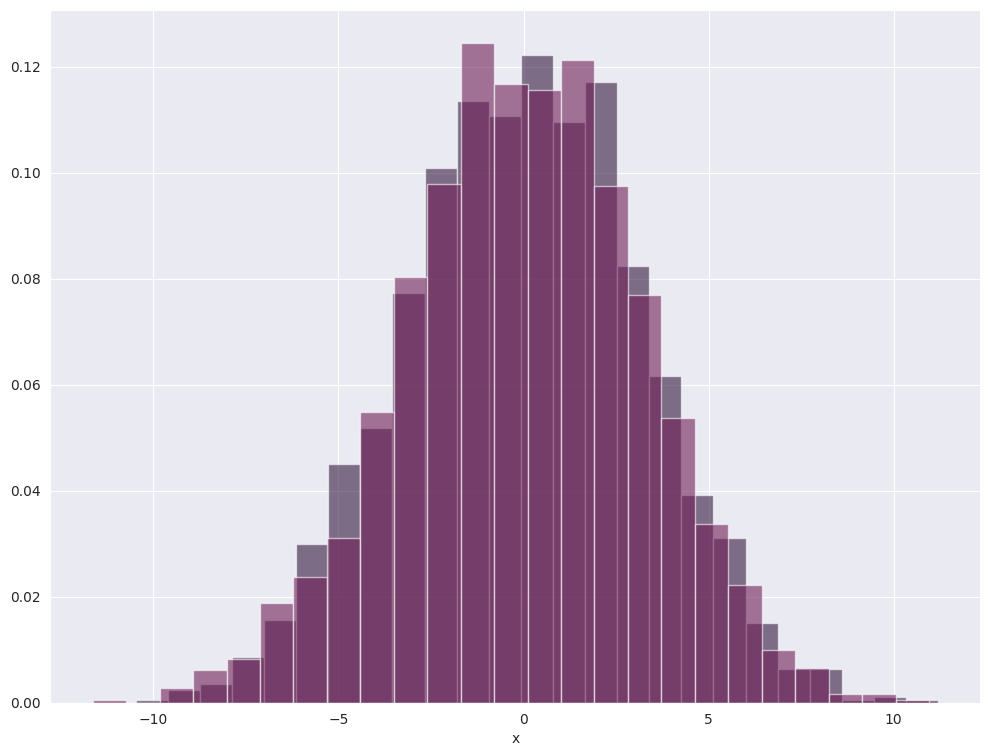

In [154]:
fig, ax=plt.subplots(figsize=(12, 9))
ax.hist(fbm_1[-1], label = "$B^H(T)$", alpha= 0.6, bins=25, density=True)
ax.hist(fbm_2[-1], label = "$T^HB^H(1)$", alpha= 0.6, bins=25, density  = True)
ax.set_xlabel("x")
plt.show()

In [151]:
stats.kstest(fbm_1[-1], fbm_2[-1]) # duze p valiu nie odzucamy

KstestResult(statistic=0.0145, pvalue=0.9845773879670964, statistic_location=-0.26063800829626765, statistic_sign=-1)

# FOU

### FOU

\begin{gather}
    Y(t) = \sigma \int_{-\infty}^{t} e^{-\lambda(t-x)}dB^H_x\\
    dY_t = -\lambda Y_t dt + \sigma dB^H_t
\end{gather}

## Sample trajectories

In [268]:
T = 10
n = 1000
H = 1/2
sigma = 1
lambd = 1
trajectories = 1000
ts = np.linspace(0, T, n) 

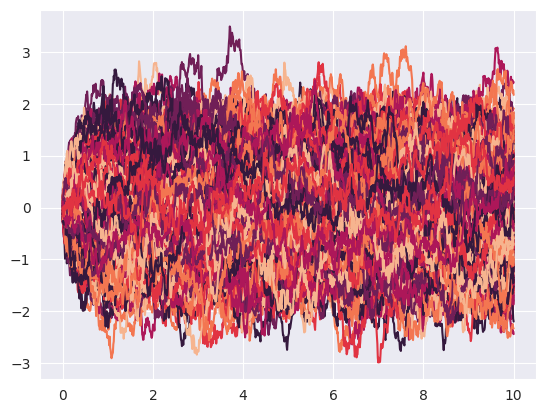

In [269]:
fig, ax=plt.subplots(figsize=(12, 9))
O_U = FOU(sigma, lambd, H, ts, trajectories = trajectories)
plt.plot(ts, O_U)
plt.show()

## Quantile line

In [271]:
T = 2
n = 1000
H = 0.666
t_s = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)

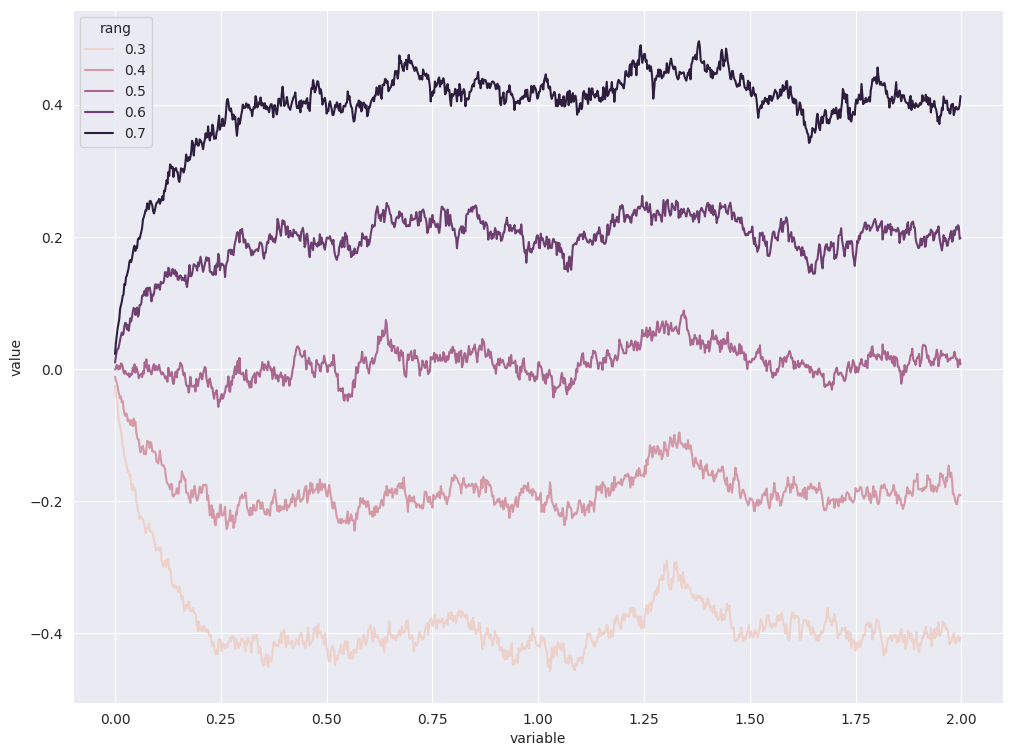

In [272]:
fig, ax=plt.subplots(figsize=(12, 9))
quantiles = np.arange(0.3, 0.8, 0.1)
quantiles_Df = get_quantils(pd.DataFrame(O_U), quantiles, t_s)
quantiles_Df["rang"] = quantiles_Df["rang"].round(2) 
sns.lineplot(data=quantiles_Df.melt("rang"), x="variable", y="value", hue="rang")
plt.savefig("latex/images/quantile_lines_OU_H_{H}.png")

## Variance in time

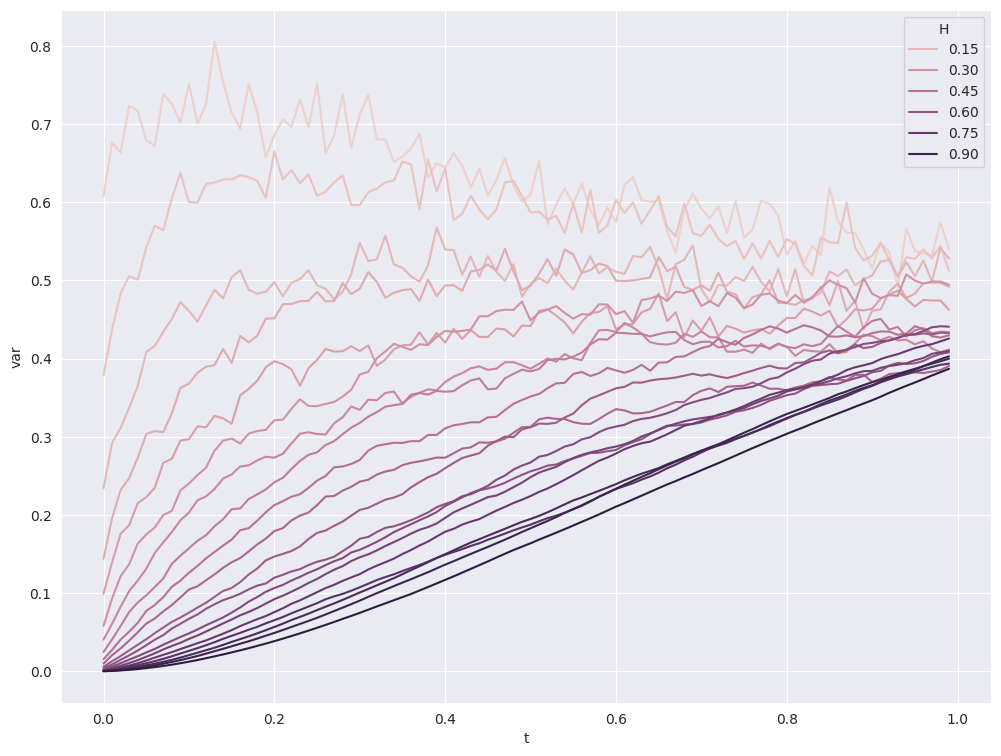

In [273]:
T = 1
n = 100
H = 0.5
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["var", "t", "H"])
for H in np.arange(dH, 1, dH):
    O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)
    _df = pd.DataFrame(np.var(O_U, 1), columns=["var"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "var", hue = "H")
plt.savefig("latex/images/variance_O_U.png")
plt.show()

## MSD

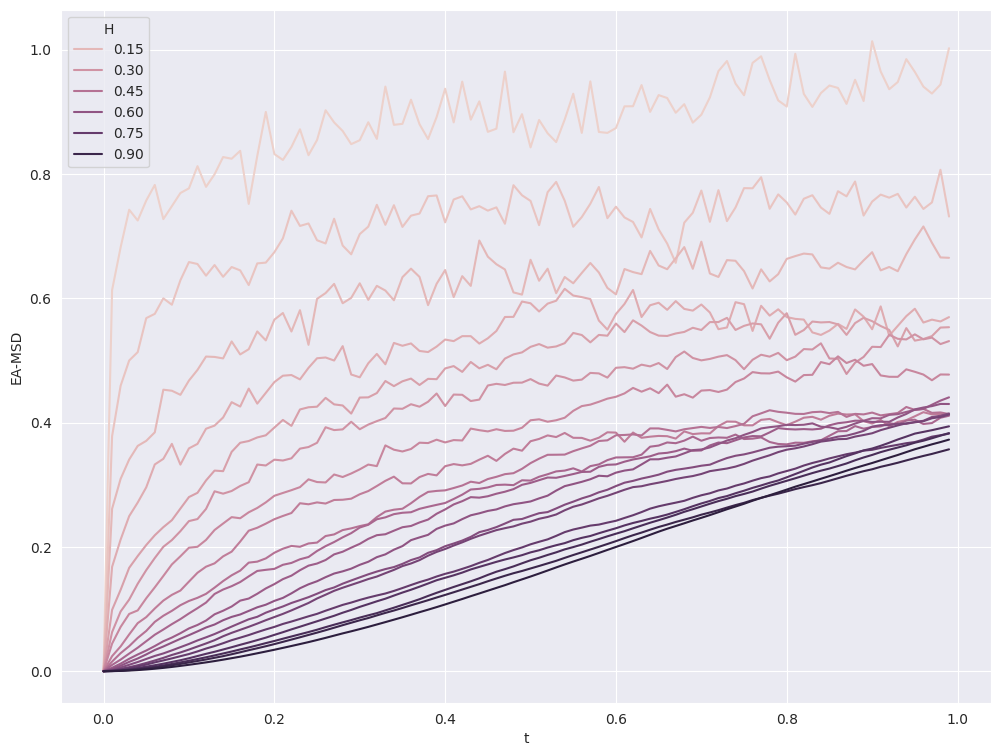

In [274]:
T = 1
n = 100
H = 0.5
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["EA-MSD", "t", "H"])
for H in np.arange(dH, 1, dH):
    O_U = FOU(sigma, lambd, H, ts, trajectories = 1000)
    _df = pd.DataFrame(EAMSD(O_U), columns=["EA-MSD"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "EA-MSD", hue = "H")
plt.savefig("latex/images/EA-MSD_O_U.png")
plt.show()   

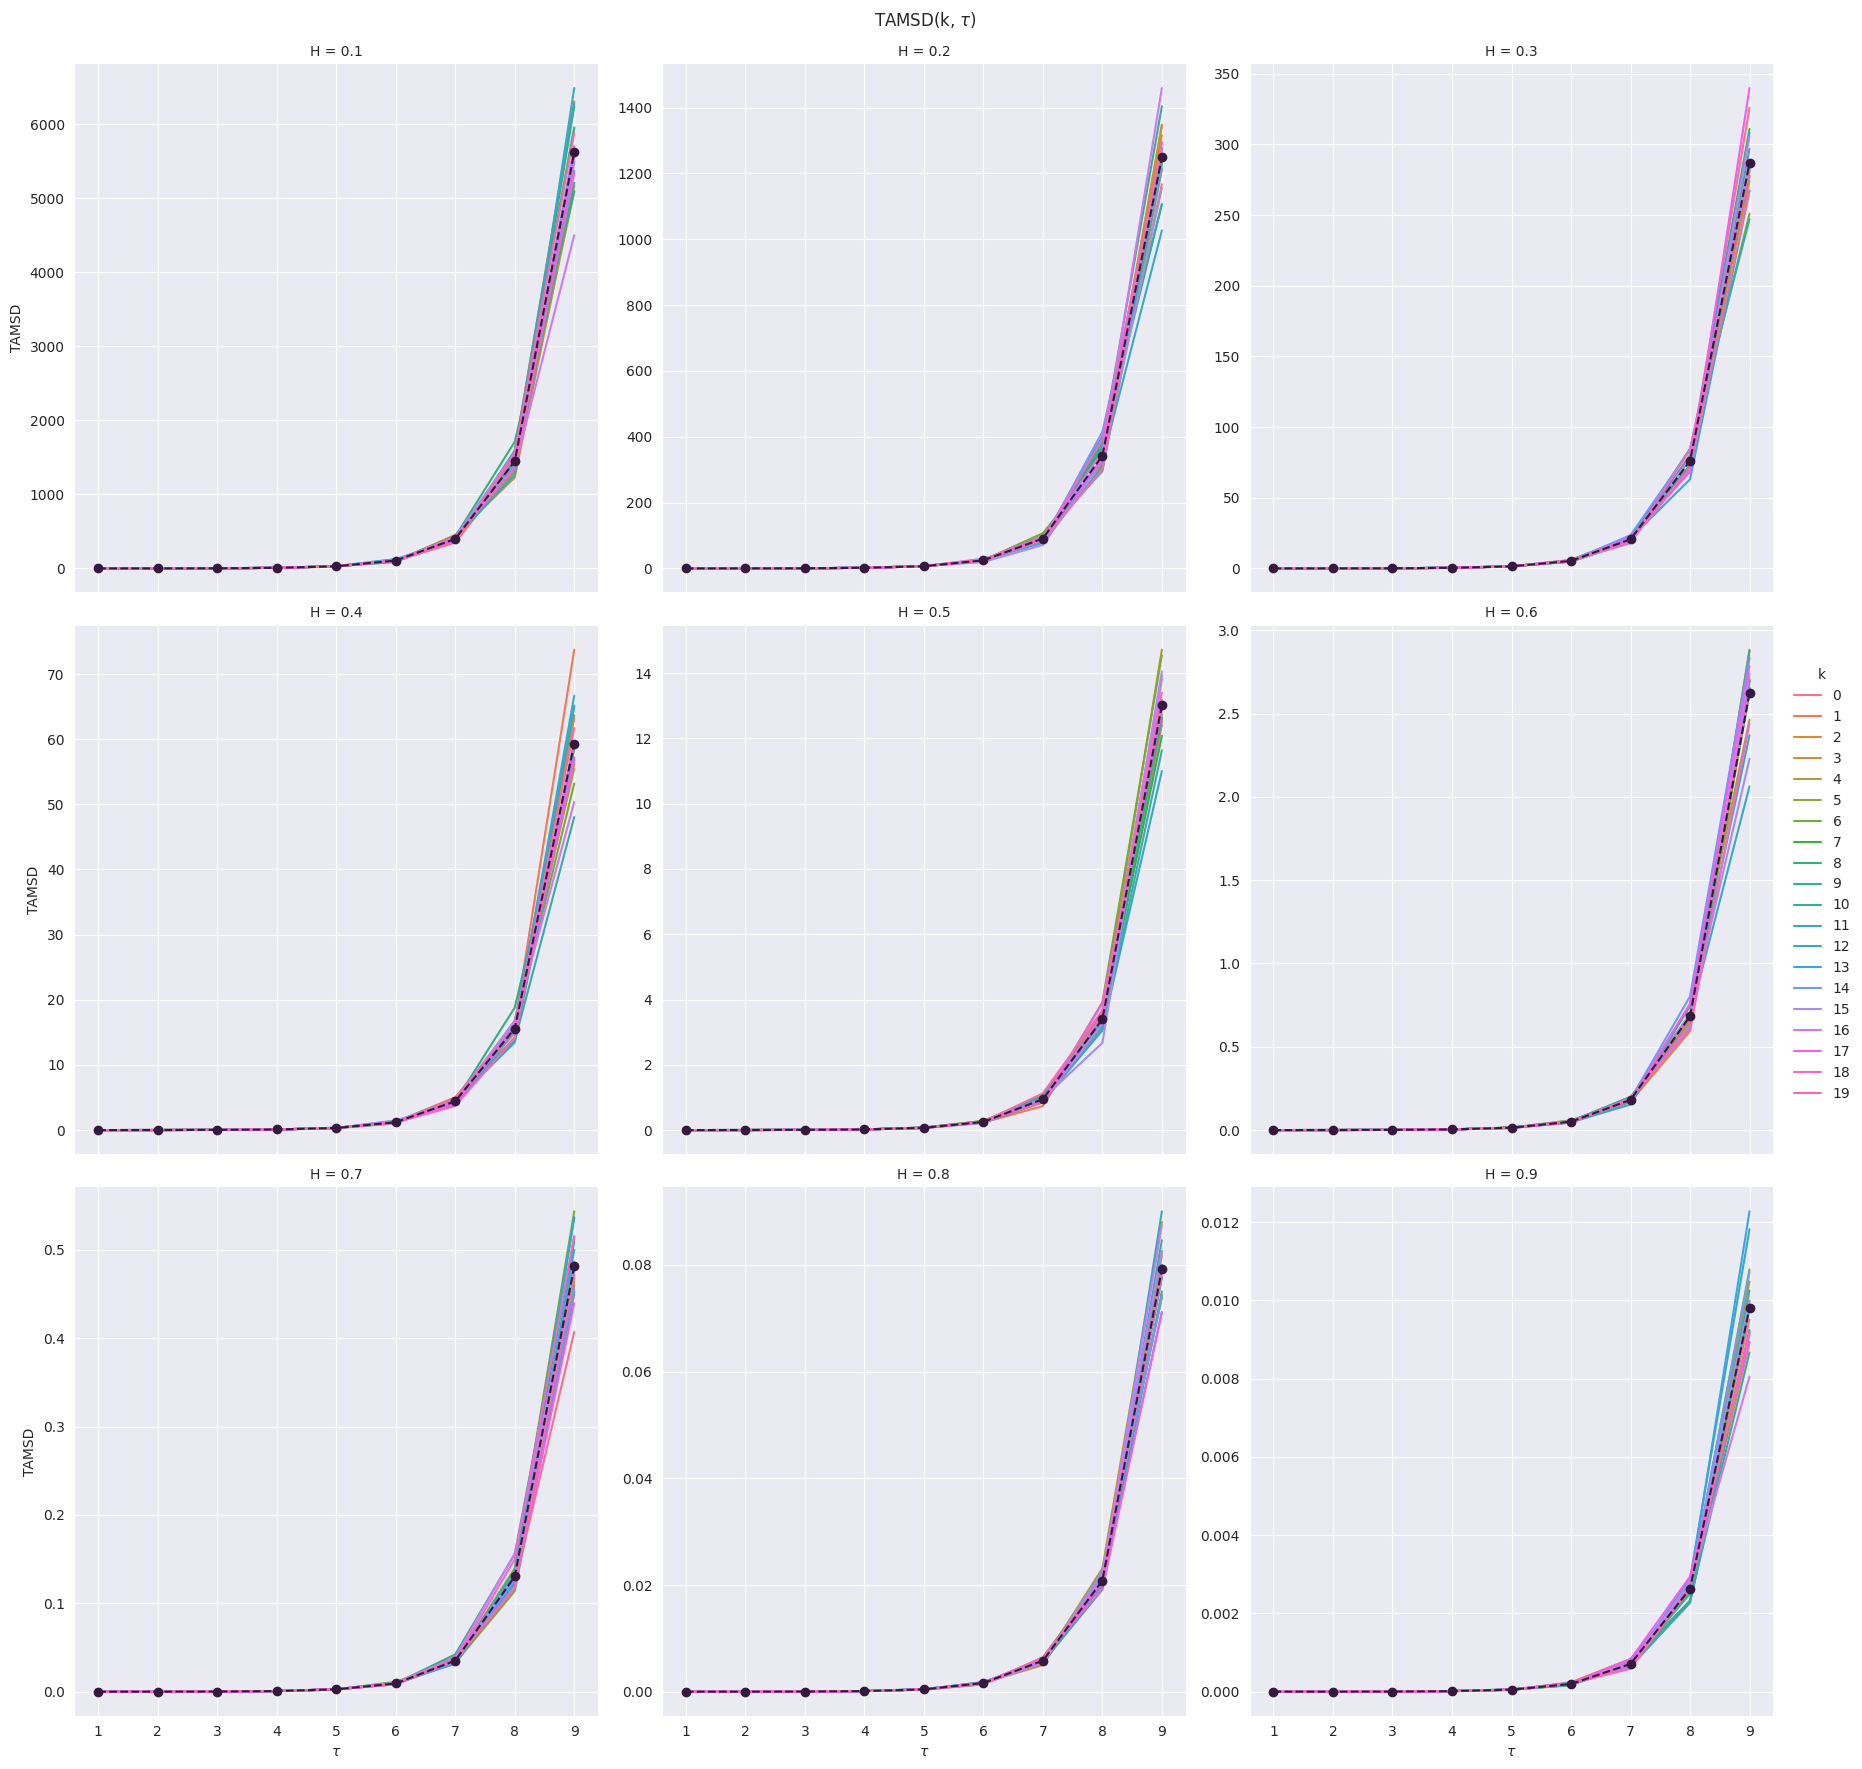

In [137]:
T = 1
n = 1000
ts = np.arange(0, T, T/n)
dH = 0.1
trajectories = 20
df = pd.DataFrame()
ks = range(trajectories)
Hs = np.arange(0.1, 1, dH).round(2)
taus = np.arange(1, 10, 1, dtype=int)
for H in Hs: 
    for tau in taus:
        O_U = FOU(sigma, lambd, H, ts, trajectories)
        _df = pd.DataFrame(TAMSD(O_U, tau), columns=["TAMSD"])
        _df["k"] = ks
        _df["tau"] = tau
        _df["H"] = H
        df = pd.concat([df, _df])
TAMSD_df = df.pivot_table(index = ["H","tau"], values="TAMSD", aggfunc="mean").reset_index()

g = sns.FacetGrid(df, col="H", col_wrap=3 , hue="k",  height=6, sharey=False)
g.map(sns.lineplot, "tau", "TAMSD")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("TAMSD(k, $\\tau$)")

for ax, H in zip(g.axes, Hs):
    data = TAMSD_df.query(f"H == {H}")
    ax.plot(taus,data["TAMSD"].values, "--", marker="o", label="test")
    ax.set_xlabel("$\\tau$")
g.add_legend()
plt.show()

## questions

### Stationary process

In [321]:
T = 10
n = 1000
H = 0.5
lambd = 1
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories= 1)
# Augmented Dickey-Fuller test
adfuller(O_U)[1] #pvalue <  0.05 so stationary

0.34901739256296466

In [322]:
kpss(O_U[500:])[1]  #pvalue < 0.05 so no stationary

0.037649599716446075

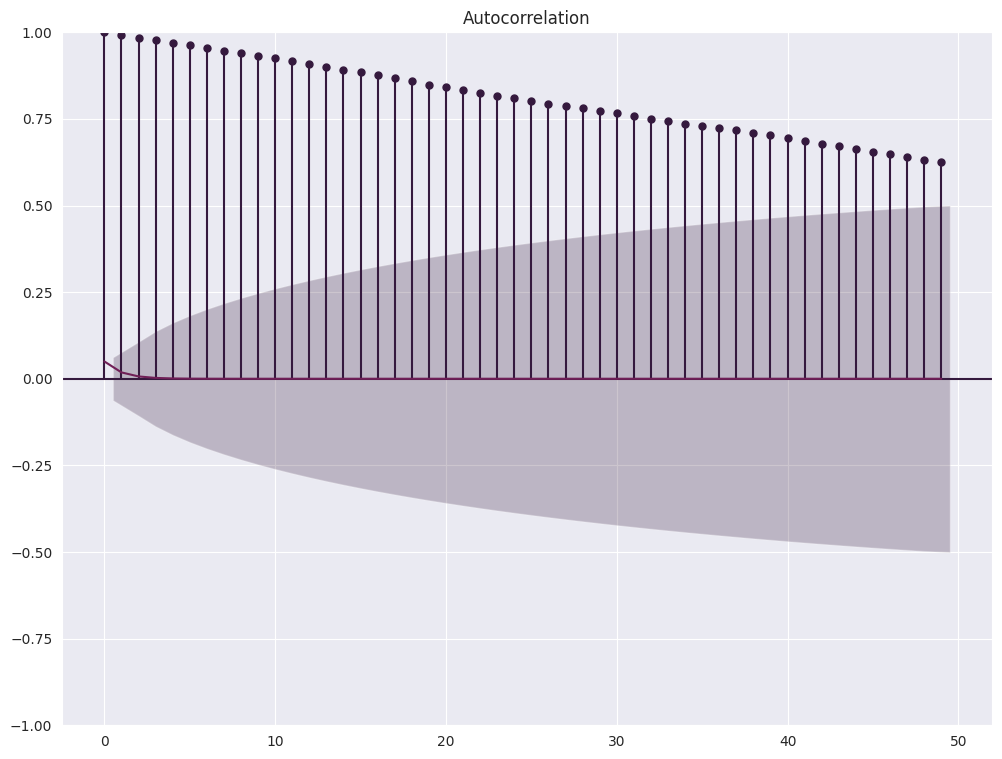

In [323]:
fig, ax=plt.subplots(figsize=(12, 9))
plot_acf(O_U, ax=ax, lags = range(0,50))
plt.plot(1/2*(T/n)**H*np.exp(-np.arange(50)))
plt.show()

### are increments of the process stationary

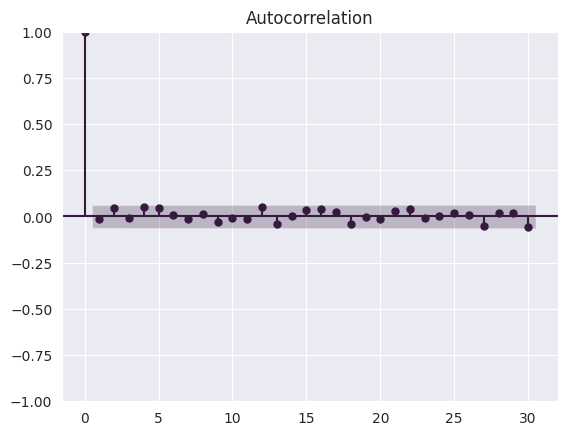

In [267]:
plot_acf(np.diff(O_U, 1, 0)[:,0])
plt.show()

### Process distribution
Proces is Gaussian

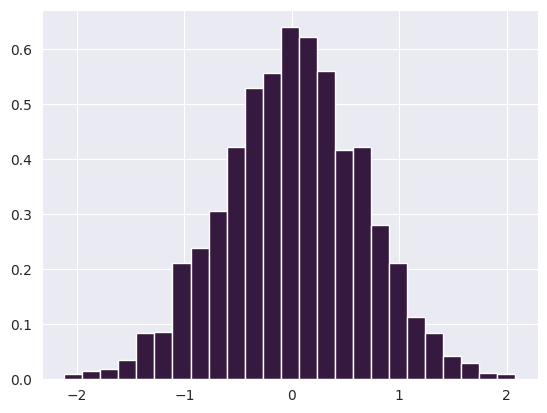

In [331]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
fix_O_U = FOU(sigma, lambd, H, ts, trajectories= 2000)[-1]
plt.hist(fix_O_U, bins = 25,density = True)
plt.show()

In [333]:
stats.shapiro(fix_O_U), stats.normaltest(fix_O_U), stats.jarque_bera(fix_O_U)

(ShapiroResult(statistic=0.9994364976882935, pvalue=0.8473778963088989),
 NormaltestResult(statistic=0.8341426319352162, pvalue=0.6589739229053804),
 SignificanceResult(statistic=0.8168899025844286, pvalue=0.6646830614280212))

### Process increment distribution

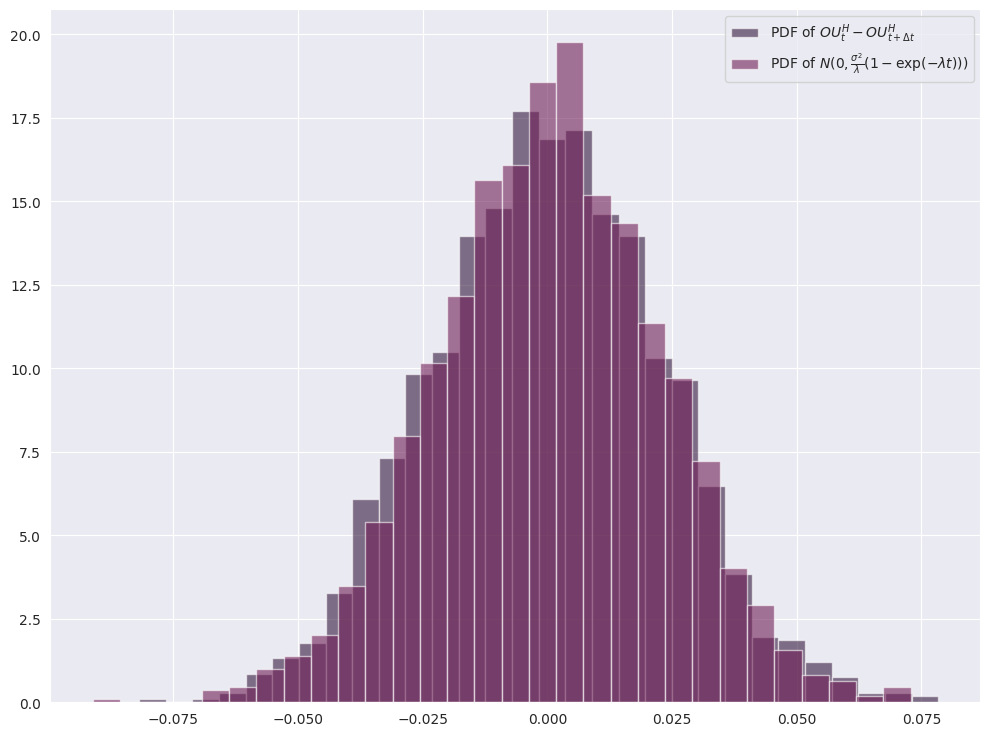

In [351]:
T = 1
n = 2000
H = 0.5
lambd = 1
sigma = 1
ts = np.arange(0, T, T/n)
O_U = FOU(sigma, lambd, H, ts, trajectories = 1)
diff_fix_O_U =  np.diff(np.squeeze(O_U))
teo_O_U = FOU(sigma, lambd, H, ts/n, trajectories= 2000)[-1]
teo_O_U = np.random.normal(0, np.sqrt(sigma**2/lambd*(1-np.exp(-lambd*T/n))), n)
fig, ax=plt.subplots(figsize=(12, 9))
plt.hist(diff_fix_O_U, density=True, bins = 30, label = "PDF of $OU^H_{t} - OU^H_{t+\Delta t}$", alpha = 0.6)
plt.hist(teo_O_U, density=True, bins = 30, label = "PDF of $N(0,\\frac{\\sigma ^2}{\\lambda}(1-\\exp(-\\lambda t)))$", alpha = 0.6)
plt.legend()
plt.show()

In [352]:
stats.kstest(diff_fix_O_U, teo_O_U) # duze p valiu nie odzucamy

KstestResult(statistic=0.026633316658329166, pvalue=0.4677507973115801, statistic_location=-0.014737875391404698, statistic_sign=1)

### Self-similar

No becos of powr-low

In [373]:
T = 5
n = 2000
H = 0.5
lambd = 1
sigma = 1
ts_1 = np.arange(0, T, T/n)
O_U_1 = FOU(sigma, lambd, H, ts_1, trajectories = 1000)

ts_2 = np.arange(0, 1, T/n)
O_U_2 = FOU(sigma, lambd, H, ts_2, trajectories = 1000)*T**H


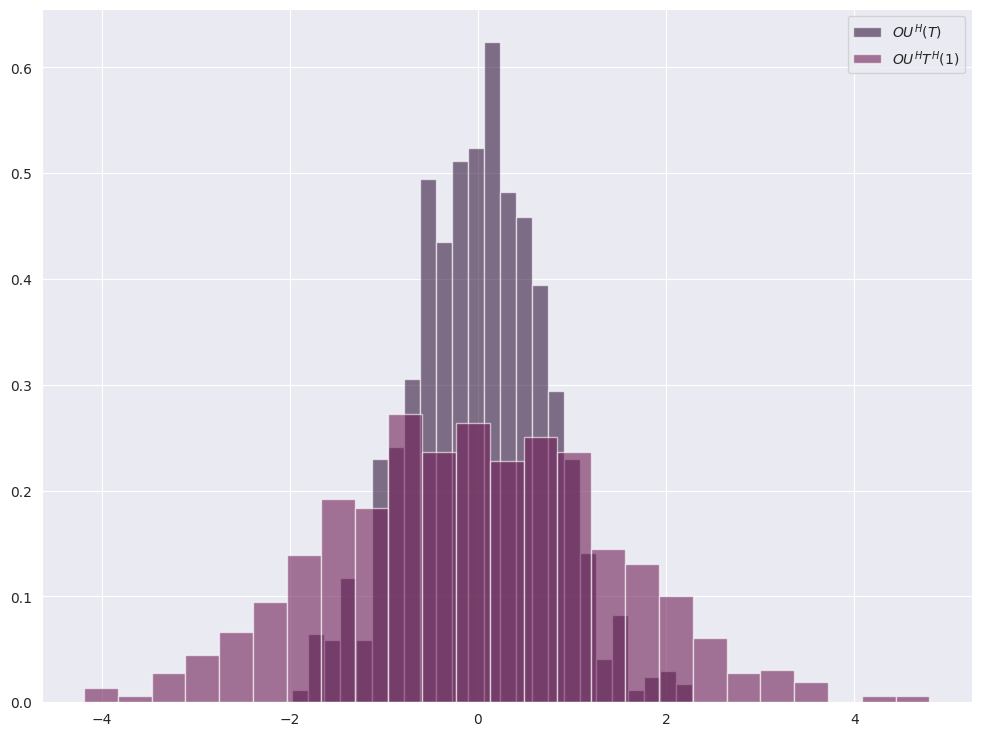

In [375]:
fig, ax=plt.subplots(figsize=(12, 9))

plt.hist(O_U_1[-1], label = "$OU^H(T)$", alpha= 0.6, bins=25, density=True)
plt.hist(O_U_2[-1], label = "$OU^H T^H(1)$", alpha= 0.6, bins=25, density  = True)
plt.legend()
plt.show()

# $\alpha-stable$

## sample trajectories

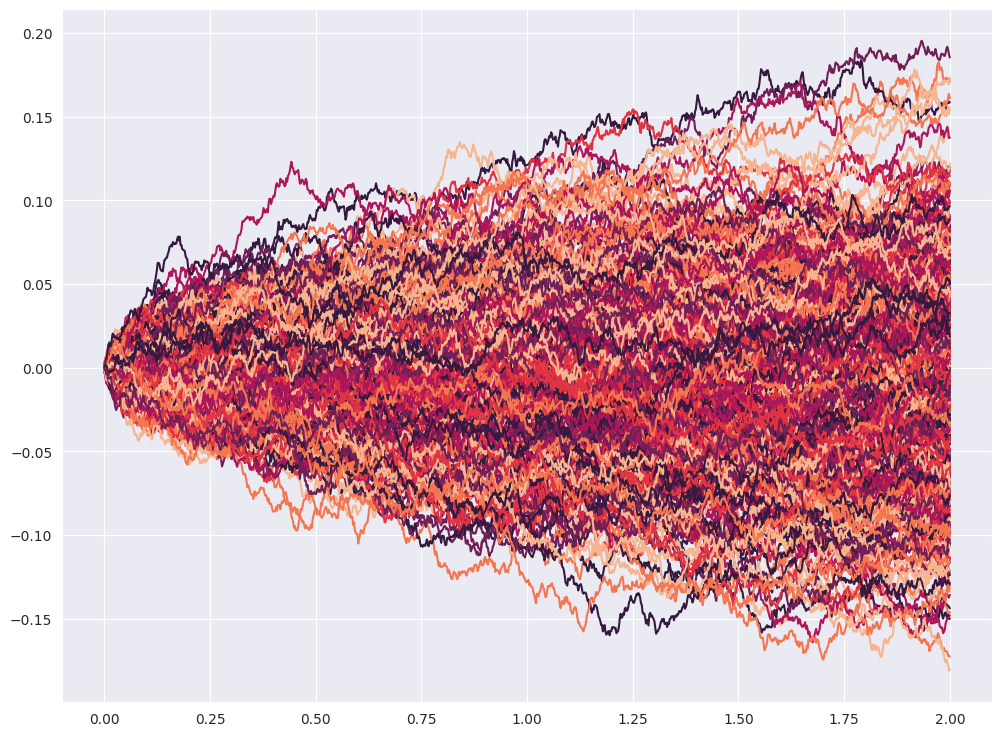

In [380]:
m =  100
M =  200
N = 1000
n =  500
H =1/2
alpha =  2
T = 2
# gamma =  (T /N) ** H
ts = np.linspace(0, T, N)

y = FAS(alpha, H, M, N, m, n)*(T/N)**H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
fig, ax=plt.subplots(figsize=(12, 9))
plt.plot(ts, FASM)
plt.show()

## Quantile lines

<Axes: xlabel='variable', ylabel='value'>

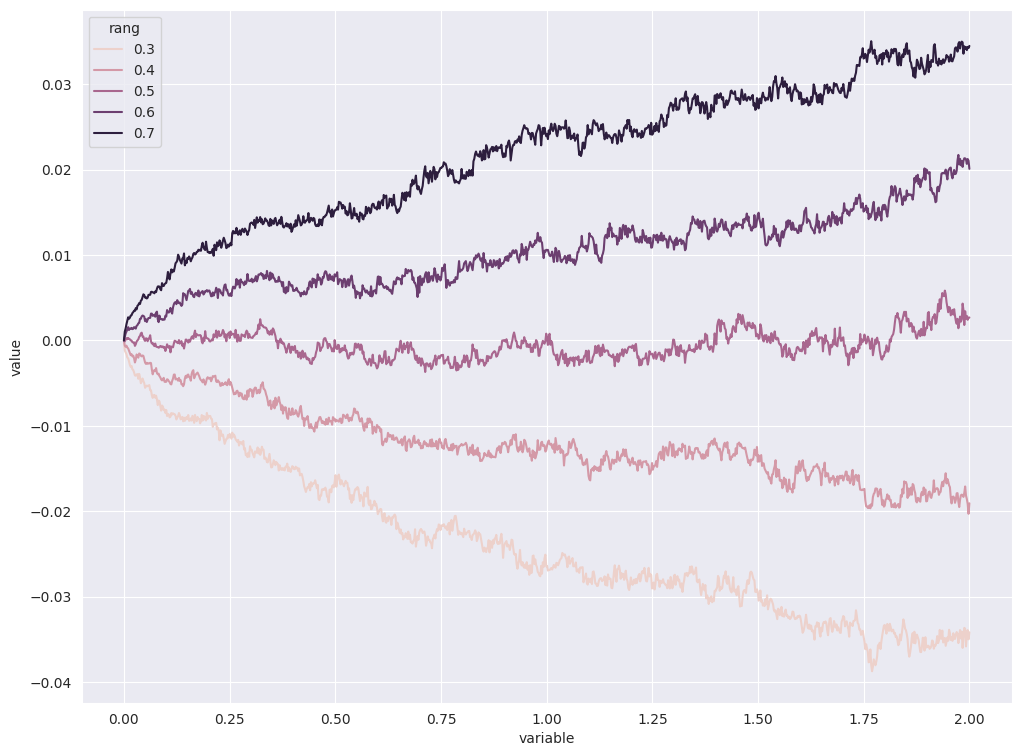

In [382]:
fig, ax=plt.subplots(figsize=(12, 9))

quantiles = np.arange(0.3, 0.8, 0.1)
quantiles_Df = get_quantils(pd.DataFrame(FASM), quantiles, ts)
quantiles_Df["rang"] = quantiles_Df["rang"].round(2) 
sns.lineplot(quantiles_Df.melt("rang"), x="variable", y="value", hue="rang")

## Variancve in time

In [384]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 100)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T

In [385]:
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["var", "t", "H"])
for H in np.arange(dH, 1, dH):
    y = FAS(alpha, H, M, N, m, 1000)*N**-H
    FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
    _df = pd.DataFrame(np.var(FASM, 1), columns=["var"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])

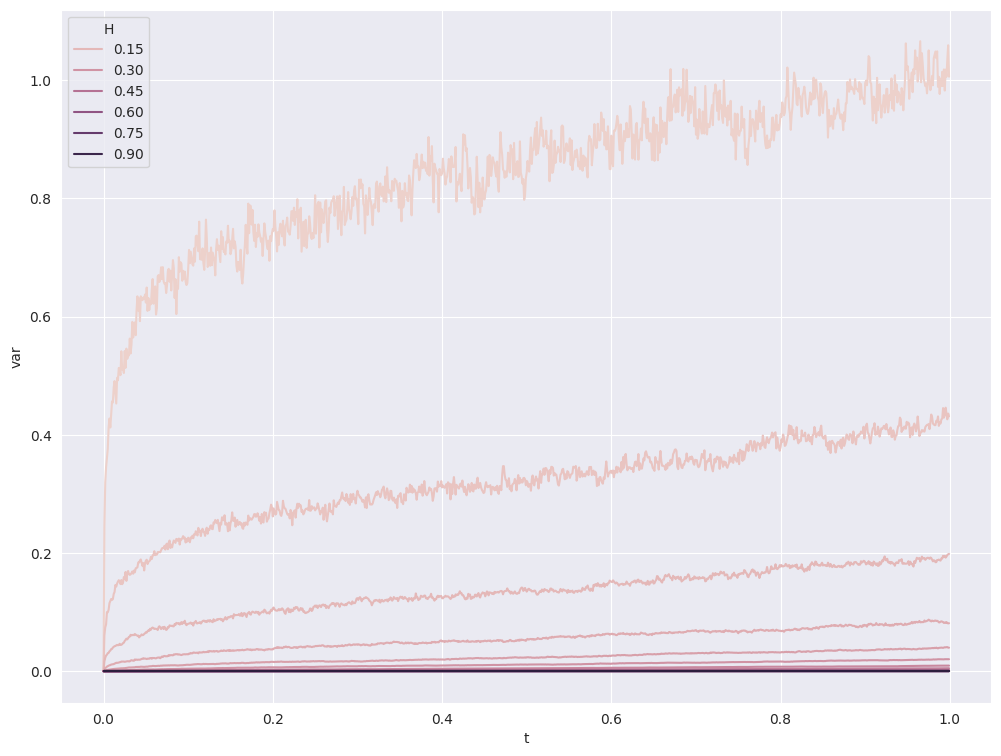

In [386]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "var", hue = "H")
plt.savefig("latex/images/variance_FASM.png")
plt.show()

## MSD

In [387]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 1000)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
dH = 0.05
trajectories = 1000
df = pd.DataFrame(columns=["EA-MSD", "t", "H"])
for H in np.arange(dH, 1, dH):
    y = FAS(alpha, H, M, N, m, 1000)*N**-H
    FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
    _df = pd.DataFrame(EAMSD(FASM), columns=["EA-MSD"])
    _df["t"] = ts
    _df["H"] = H
    df = pd.concat([df, _df])

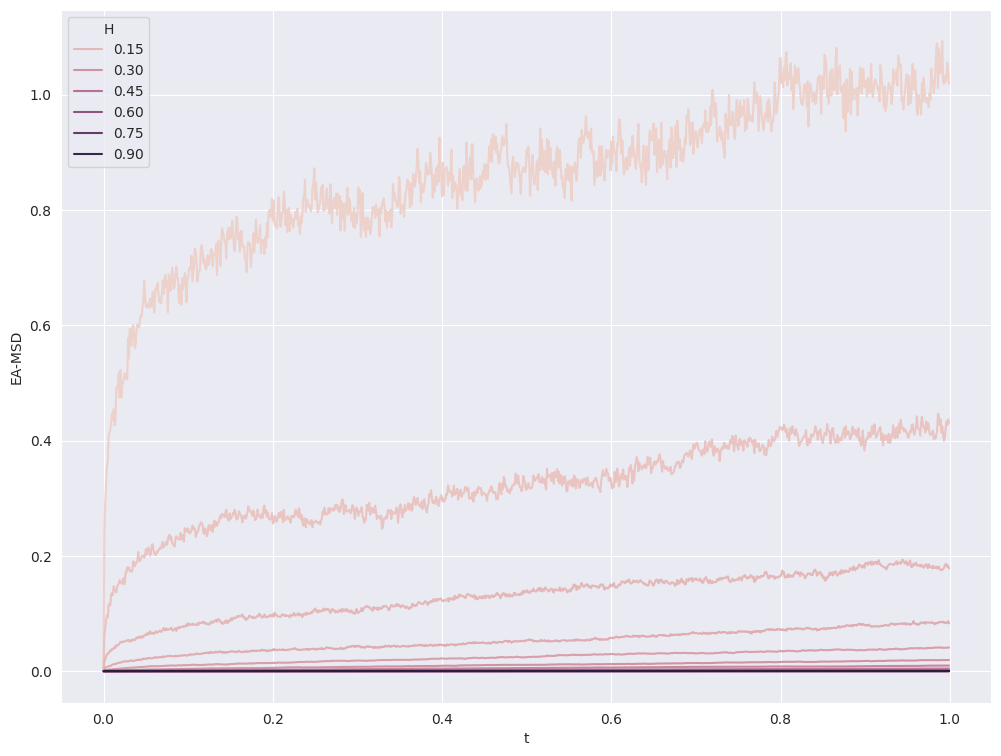

In [388]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.lineplot(data=df, x = "t", y = "EA-MSD", hue = "H")
plt.show()


In [389]:
T = 1
n = 20
ts = np.arange(0, T, T/n)
dH = 0.1
trajectories = 20
df = pd.DataFrame()
ks = range(trajectories)
Hs = np.arange(0.1, 1, dH).round(2)
taus = np.arange(1, 10, 1, dtype=int)
for H in Hs: 
    for tau in taus:
        y = FAS(alpha, H, M, N, m, 20)*N**-H
        FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
        _df = pd.DataFrame(TAMSD(FASM, tau), columns=["TAMSD"])
        _df["k"] = ks
        _df["tau"] = tau
        _df["H"] = H
        df = pd.concat([df, _df])
TAMSD_df = df.pivot_table(index = ["H","tau"], values="TAMSD", aggfunc="mean").reset_index()


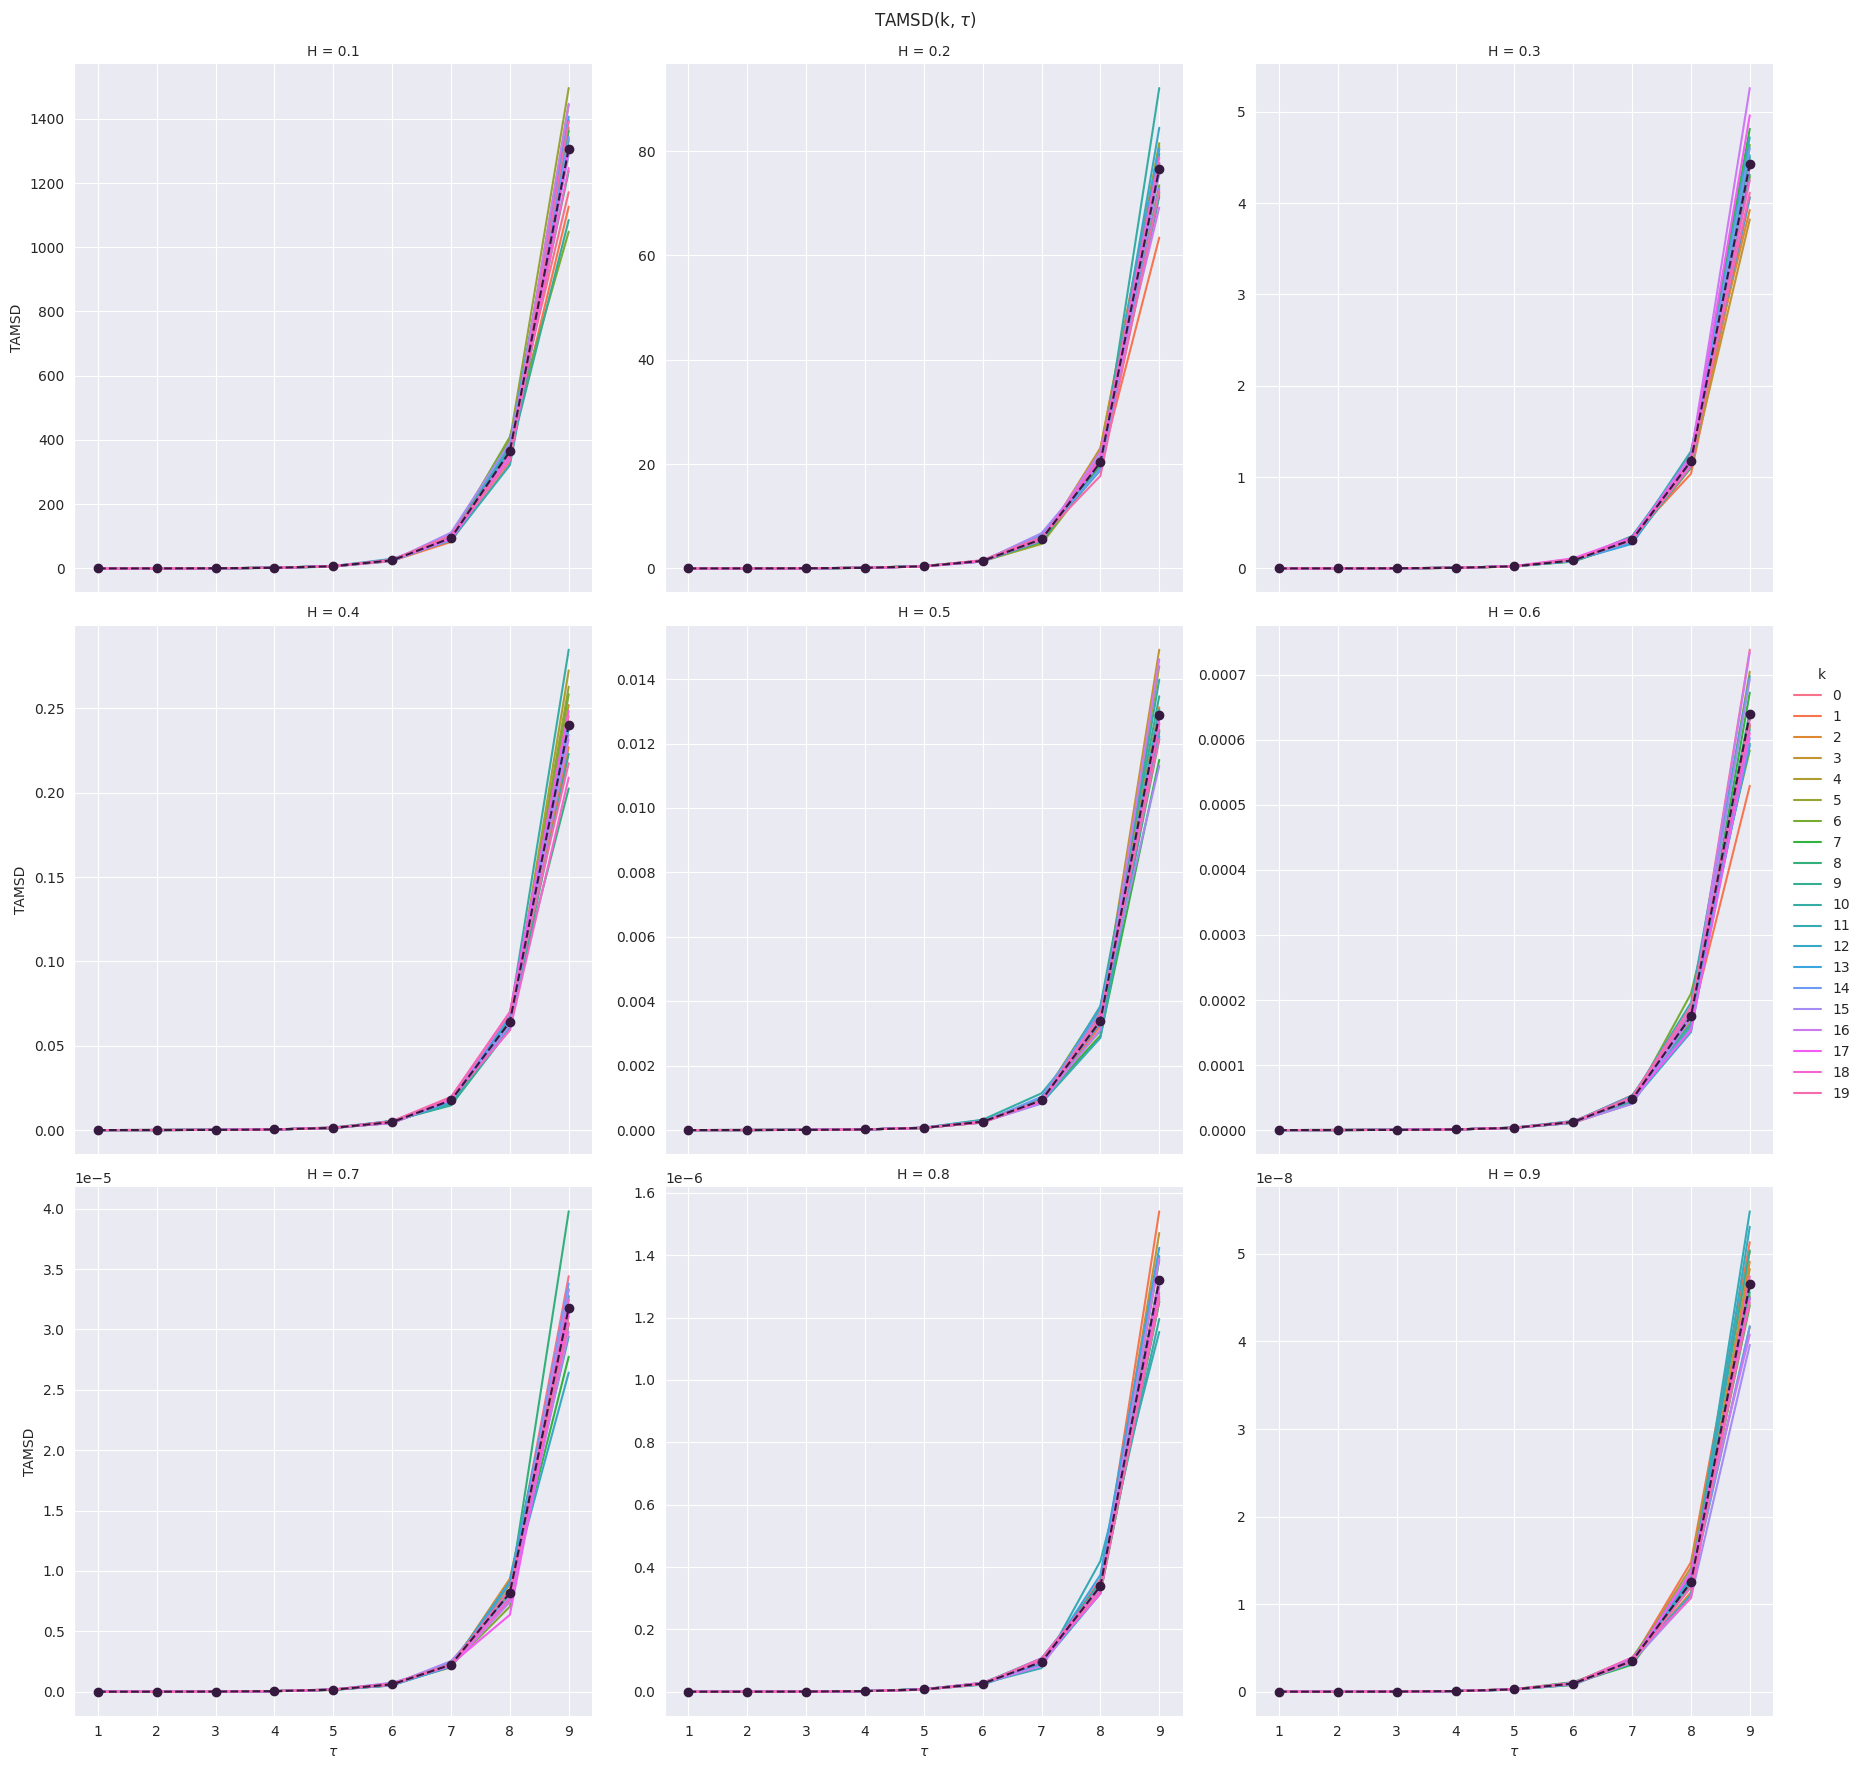

In [390]:
g = sns.FacetGrid(df, col="H", col_wrap=3 , hue="k",  height=6, sharey=False)
g.map(sns.lineplot, "tau", "TAMSD")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("TAMSD(k, $\\tau$)")

for ax, H in zip(g.axes, Hs):
    data = TAMSD_df.query(f"H == {H}")
    ax.plot(taus,data["TAMSD"].values, "--", marker="o", label="test")
    ax.set_xlabel("$\\tau$")
g.add_legend()
plt.show()


## Questions

In [391]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 1)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T

In [392]:
adfuller(FASM)[1] #pvalue> 0.05 so no stationary

0.6801880337118777

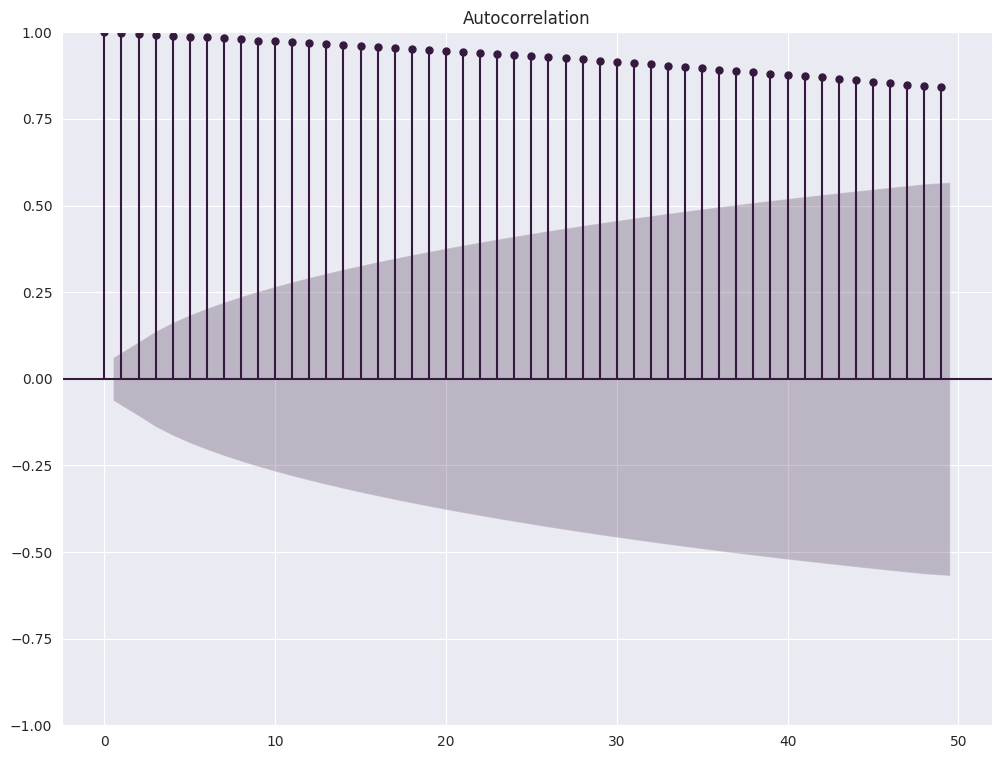

In [393]:
fig, ax=plt.subplots(figsize=(12, 9))
plot_acf(FASM, ax=ax, lags = range(0,50))
plt.show()

### are increments of the process stationary

In [394]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 1)*N**-H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T
y = FAS(alpha, H, M, N, m, 2000)*N**-H
FASM_2 = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T[-1]

adfuller(np.diff(FASM,1,0))[1] # pvalue < 0.05 nie odzucamy

0.0

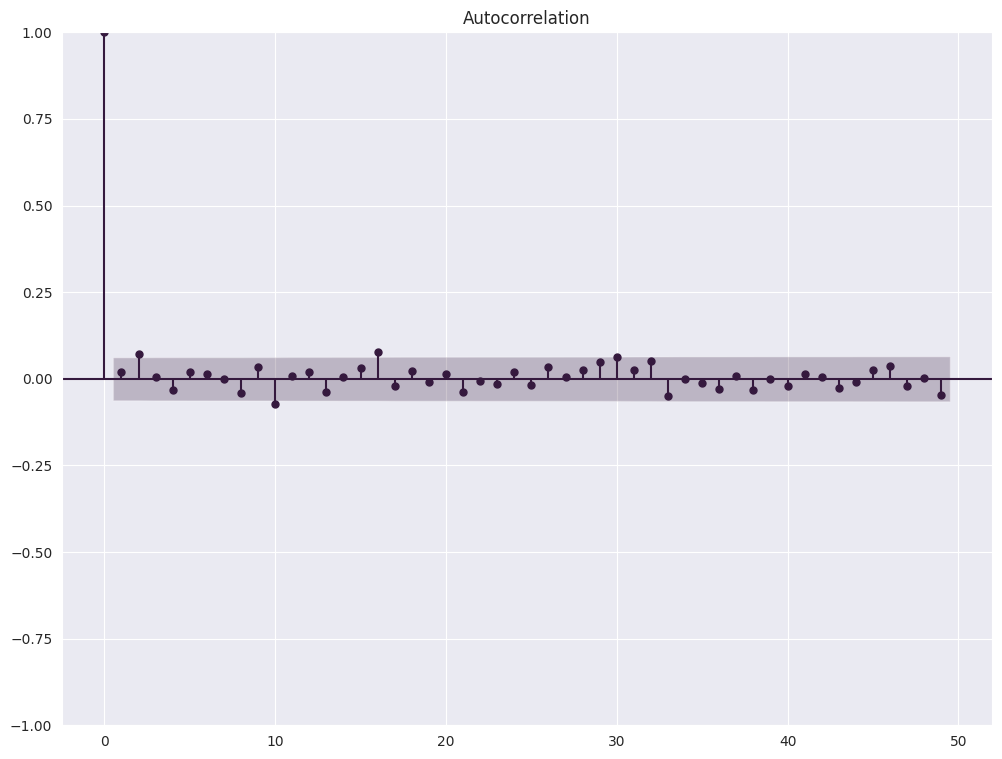

In [395]:
fig, ax=plt.subplots(figsize=(12, 9))
plot_acf(np.diff(FASM,1,0), ax=ax, lags = range(0,50))
plt.show()

### process distribution 

Process is levi-stable

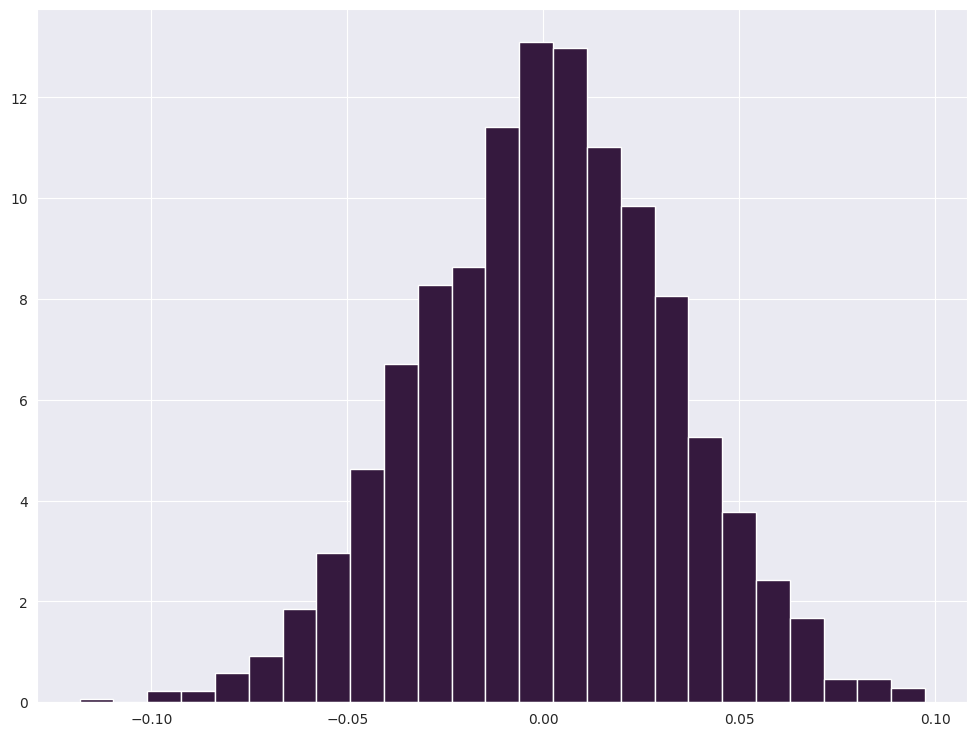

In [399]:
T = 1
n = 1000
H = 0.5
ts = np.arange(0, T, T/n)
y = FAS(alpha, H, M, N, m, 2000)*(T/N)**H
fix_FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1).T[-1]
fig, ax=plt.subplots(figsize=(12, 9))
plt.hist(fix_FASM, bins = 25,density = True)
plt.show()### process increments distribution 

In [405]:
stats.kstest(fix_FASM, stats.levy_stable(2.0, -1.0, -0.00018574124807356978, 0.023115599604696627).cdf)

KstestResult(statistic=0.03027112269971416, pvalue=0.05014900654699239, statistic_location=-0.008995917134417435, statistic_sign=-1)

In [401]:
alpha

2

In [407]:
stats.levy_stable.fit(fix_FASM) 

(2.0, -1.0, 0.001587313774358012, 0.02264369321719197)

### process increments distribution 

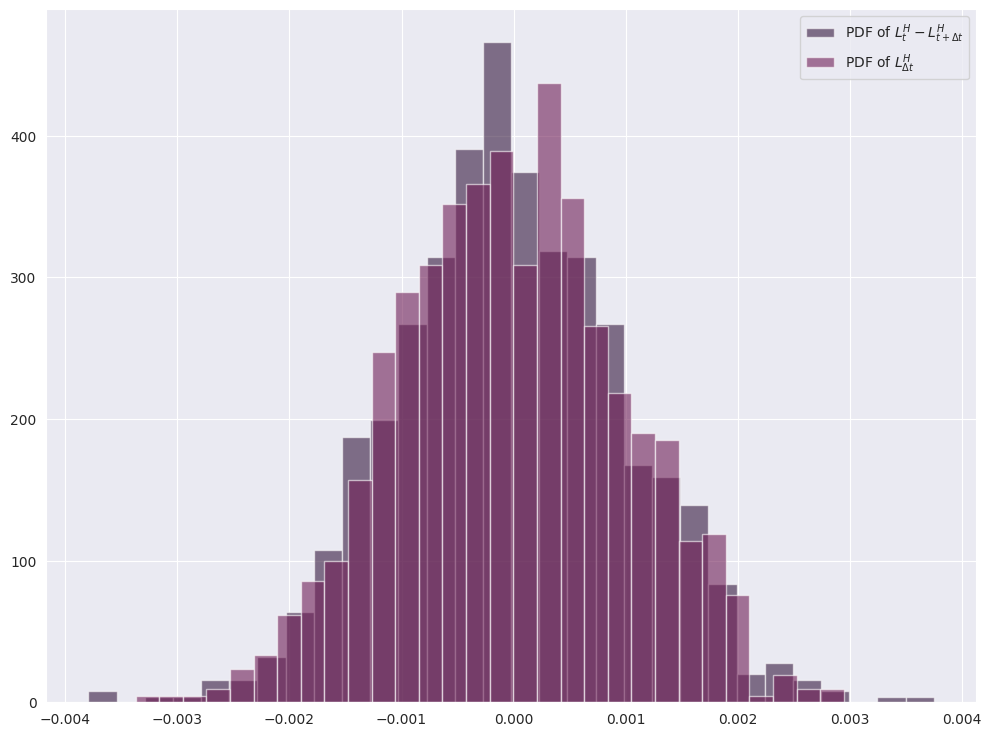

In [418]:
T = 1
n = 2000
H = 0.5
ts = np.arange(0, T, T/n) 
y = FAS(alpha, H, M, N, m, 1)*(T/N)**H
FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1)

diff_fix_FASM =  np.diff(np.squeeze(FASM))
teo_FASM = FAS(alpha, H, M, N, m, 1)*(T/N)**H
# teo_FASM = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1000)[-1]

fig, ax=plt.subplots(figsize=(12, 9))
plt.hist(diff_fix_FASM, density=True, bins = 30, label = "PDF of $L^H_{t} - L^H_{t+\Delta t}$", alpha = 0.6)
plt.hist(teo_FASM[0], density=True, bins = 30, label = "PDF of $L^H_{\Delta t}$", alpha = 0.6)
plt.legend()
plt.show()

In [420]:
stats.kstest(diff_fix_FASM, teo_FASM[0]) # duze p valiu nie odzucamy

KstestResult(statistic=0.030617617617617617, pvalue=0.718135128108371, statistic_location=0.00023052142704780947, statistic_sign=1)

### Self-similar

In [436]:
T = 10
n = 2000
H = 0.5
ts = np.arange(0, T, T/n) 
y = FAS(alpha, H, M, N, m, 2000)*(T/N)**H
FASM_1 = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1)

y = FAS(alpha, H, M, N, m, 2000)*(1/N)**H
FASM_2 = np.cumsum(np.insert(y[:,:-1], 0, 0, axis=1), 1)*T**H

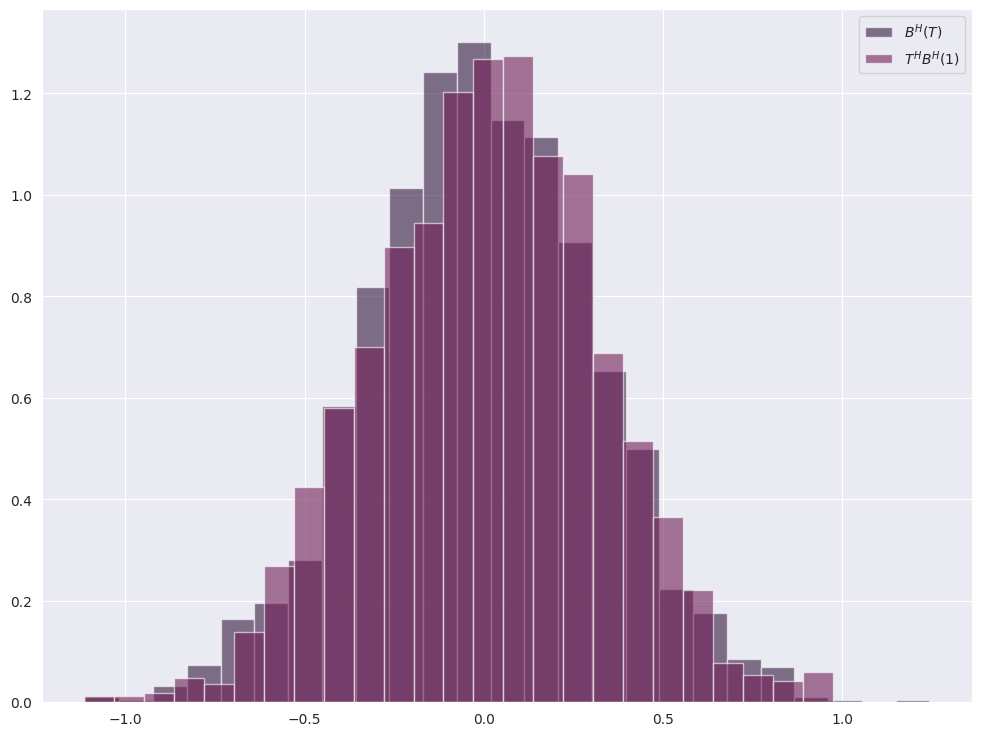

In [437]:
fig, ax=plt.subplots(figsize=(12, 9))
plt.hist(FASM_1[:,-1], label = "$B^H(T)$", alpha= 0.6, bins=25, density=True)
plt.hist(FASM_2[:,-1], label = "$T^HB^H(1)$", alpha= 0.6, bins=25, density  = True)
plt.legend()
plt.show()

In [431]:
stats.kstest(FASM_1[:, -1], FASM_2[:, -1])

KstestResult(statistic=0.033, pvalue=0.22624166055654427, statistic_location=0.10508857306743757, statistic_sign=-1)

# ex 2

In [7]:
def check_time(a, b):
    if a==0:
        if b==0:
            return np.nan
        else:
            return b
    elif b==0:
        if a==0 :
            return np.nan
        else:
            return a
    else:
        return min(a, b)
    
def hit_time(X, a, b):
    # return check_time(np.argmin(X<a),np.argmin(X>b))
    return check_time(np.argmin(X>a),np.argmin(X<b))

def hit_b(X, a, b):
    return np.argmin(X>a)>np.argmin(X<b)

In [8]:
alpha = 2
N = 1000
T = 2000
n = 2000
ts = np.linspace(0, T ,N)
SaSLn = np.array([alpha_stable_process(alpha, 0, N, T) for _ in range(n)])

In [440]:
a_s = np.linspace(-199, 0, 200).round(2)
b_s = np.linspace(0, 199, 200).round(2)
df = pd.DataFrame(columns=a_s, index=b_s[::-1])
for a in a_s:
    for b in b_s:
        taus = np.apply_along_axis(hit_time, 0, SaSLn, a, b)
        df.loc[b,a] = np.nanmean(taus)

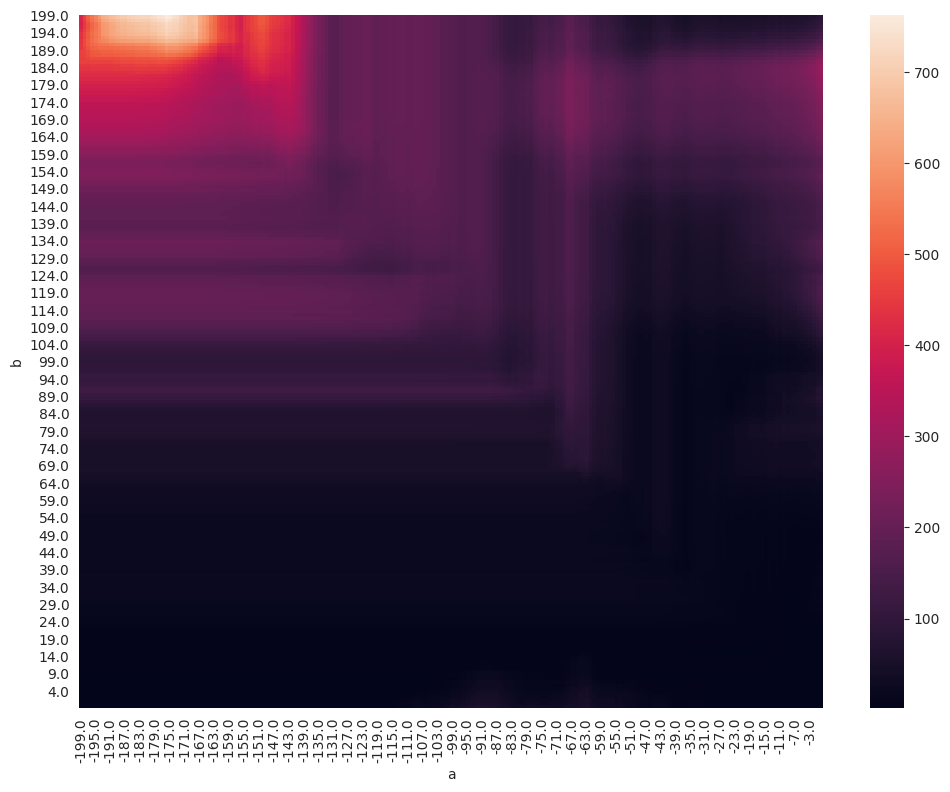

In [441]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.heatmap(df.astype(np.float64), ax = ax, xticklabels=4)
ax.set_xlabel("a")
ax.set_ylabel("b")
plt.show()

In [12]:
a_s = np.linspace(-10, 0, 10).round(2)
b_s = np.linspace(0, 10, 10).round(2)
df2 = pd.DataFrame(columns=a_s, index=b_s[::-1])
for a in a_s:
    for b in b_s:
        taus = np.apply_along_axis(hit_b, 0, SaSLn, a, b)
        df2.loc[b, a] = np.nanmean(taus)

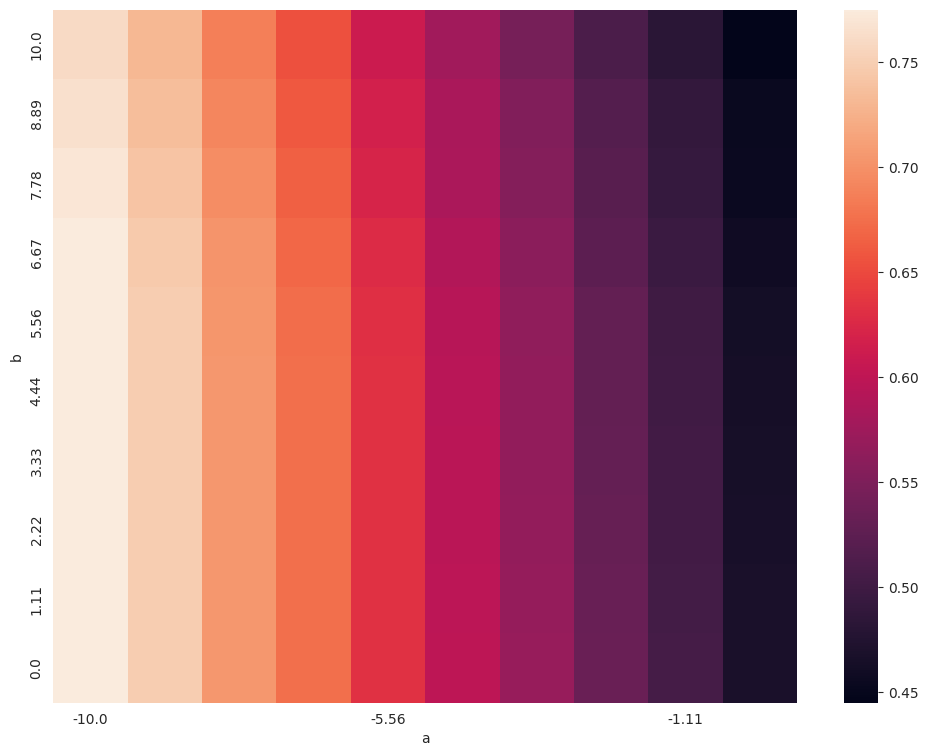

In [13]:
fig, ax=plt.subplots(figsize=(12, 9))
sns.heatmap(df2.astype(np.float64), ax = ax, xticklabels=4)
ax.set_xlabel("a")
ax.set_ylabel("b")
plt.show()